<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N_0607b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 122.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 97.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=1a80640

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

from PIL import Image


In [9]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3, data_transforms4, data_transforms5

from model_container import ModelContainer



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Create Datasets and DataLoaders

In [ ]:

#create the datasets
#train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



Creating an alternative dataframe where the val images are randomly chosen rather than the midpoint as originally performed. Also, creating a larger train dataset to explore. 

In [ ]:
# val_ran_df = create_dataset(val_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior = 'random', a=0.1, b=0.9)
# train_large_df = create_dataset(train_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior='range', a=0.1, b=0.9)

# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')
# train_large_df.to_pickle('/content_grdive/MyDrive/train_large_df.pkl')

In [ ]:
# val_ran_df
# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [10]:
# have already pickled the datasets and just loading here
train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')
val_ran_df = pd.read_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [16]:
# Get the data loaders
# dataloaders - vanilla, no augmentation just cropping and resizing, number channels to 1, and to tensor
# dataloaders2 - some augmentation (color jitter)
# dataloaders3 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 2 to highlight bright pixels
# dataloaders4 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 0.5 for comparison

batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
train_loader4, val_loader4, test_loader4, dataset_sizes4 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms4)
train_loader5, val_loader5, test_loader5, dataset_sizes5 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms5)



dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}
dataloaders4 = {'train': train_loader4, 'val': val_loader4, 'test': test_loader4}
dataloaders5 = {'train': train_loader5, 'val': val_loader5, 'test': test_loader5}


# Explore Base Model Archictectures#

Comparing the accuracy of various models on the validation dataset. There are two variations of the ResNet50 model, the first (CustomResNet) with a single fully connected layer as the head and the second (CustomResNetb) with two fully connected layers separated by ReLU. There is also a DenseNet model with a single fully connected layer as the head. Both SGD and Adam optimizers are used for each combination, as are Cross Entropy Loss and a custom Focal Loss. 

For data preparation, there are four different combinations: a vanilla transformer that only uses cropping and resizing, transformer2 which also uses some augmentation (color jitter), and transformers 3 and 4 which use a gamma function to alter the image (presumably to highlight bright pixels) with two different settings for comparison (although will likely perform the last comparison only on the 'best model' from the other comparisons. 

In [20]:
# Different combinations to evaluate
models = [CustomDenseNet]
loss_funcs = [FocalLoss] 
loaders = ['dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2, 'dataloaders3': dataloaders3, 'dataloaders4': dataloaders4, 'dataloaders5': dataloaders5}
optimizers = ['Adam']
optim_dict = {

    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomResNet50, dataloaders, SGD, FocalLoss


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


Epoch 0/14
----------
train Loss: 1.4503 Acc: 0.4324
val Loss: 0.7959 Acc: 0.6554

Epoch 1/14
----------
train Loss: 0.5133 Acc: 0.7589
val Loss: 0.5296 Acc: 0.7373

Epoch 2/14
----------
train Loss: 0.2762 Acc: 0.8539
val Loss: 0.4592 Acc: 0.7684

Epoch 3/14
----------
train Loss: 0.1642 Acc: 0.9145
val Loss: 0.4487 Acc: 0.7740

Epoch 4/14
----------
train Loss: 0.1044 Acc: 0.9525
val Loss: 0.4159 Acc: 0.8079

Epoch 5/14
----------
train Loss: 0.0643 Acc: 0.9744
val Loss: 0.4134 Acc: 0.8051

Epoch 6/14
----------
train Loss: 0.0458 Acc: 0.9825
val Loss: 0.4060 Acc: 0.8107

Epoch 7/14
----------
train Loss: 0.0329 Acc: 0.9912
val Loss: 0.3855 Acc: 0.8023

Epoch 8/14
----------
train Loss: 0.0286 Acc: 0.9920
val Loss: 0.3870 Acc: 0.8107

Epoch 9/14
----------
train Loss: 0.0268 Acc: 0.9949
val Loss: 0.4133 Acc: 0.8079

Epoch 10/14
----------
train Loss: 0.0237 Acc: 0.9963
val Loss: 0.3898 Acc: 0.8023

Epoch 11/14
----------
train Loss: 0.0261 Acc: 0.9949
val Loss: 0.3913 Acc: 0.8051

Ep

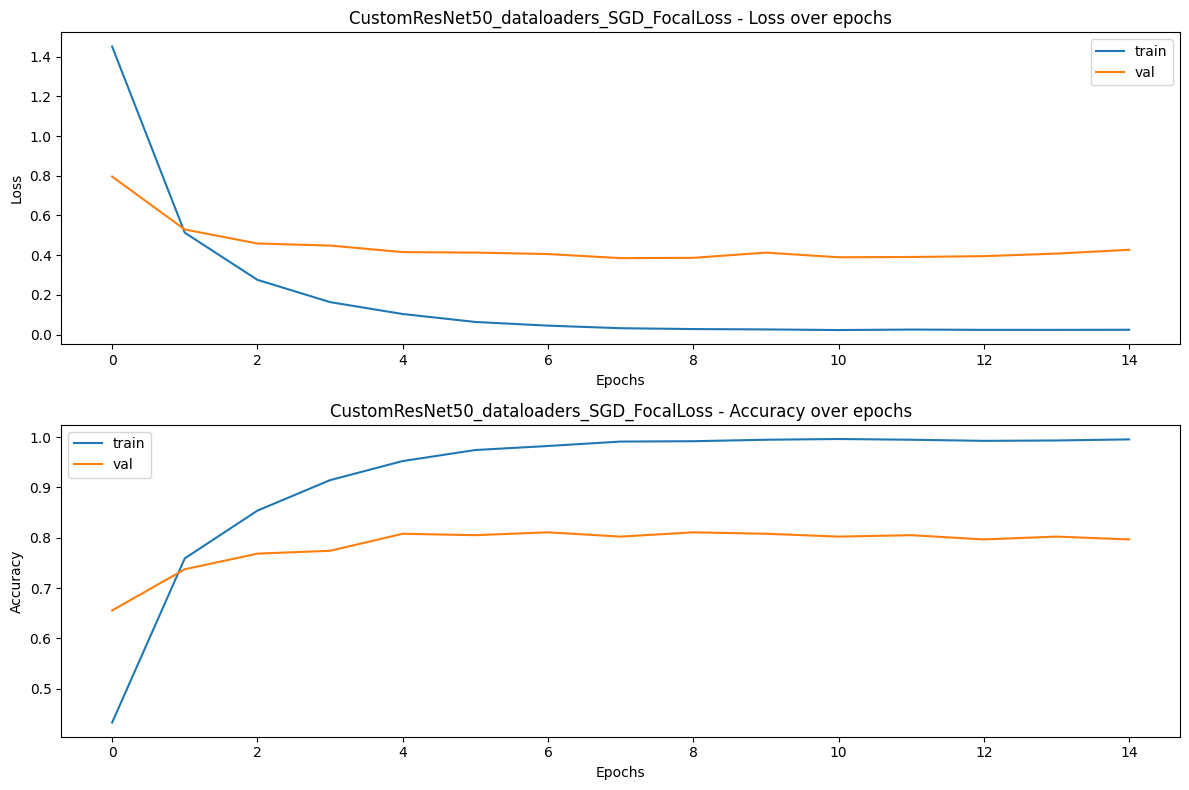


Training with CustomResNet50, dataloaders, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9772 Acc: 0.4032
val Loss: 1.3080 Acc: 0.6695

Epoch 1/14
----------
train Loss: 0.9488 Acc: 0.7356
val Loss: 0.8971 Acc: 0.7260

Epoch 2/14
----------
train Loss: 0.5950 Acc: 0.8364
val Loss: 0.7201 Acc: 0.7768

Epoch 3/14
----------
train Loss: 0.3843 Acc: 0.9007
val Loss: 0.6096 Acc: 0.8051

Epoch 4/14
----------
train Loss: 0.2557 Acc: 0.9416
val Loss: 0.6593 Acc: 0.8023

Epoch 5/14
----------
train Loss: 0.1694 Acc: 0.9664
val Loss: 0.5922 Acc: 0.8192

Epoch 6/14
----------
train Loss: 0.1209 Acc: 0.9817
val Loss: 0.5943 Acc: 0.8305

Epoch 7/14
----------
train Loss: 0.0894 Acc: 0.9883
val Loss: 0.5830 Acc: 0.8136

Epoch 8/14
----------
train Loss: 0.0800 Acc: 0.9890
val Loss: 0.5795 Acc: 0.8136

Epoch 9/14
----------
train Loss: 0.0766 Acc: 0.9934
val Loss: 0.5929 Acc: 0.8192

Epoch 10/14
----------
train Loss: 0.0829 Acc: 0.9898
val Loss: 0.5943 Acc: 0.8192

Epoch 11/14
--------

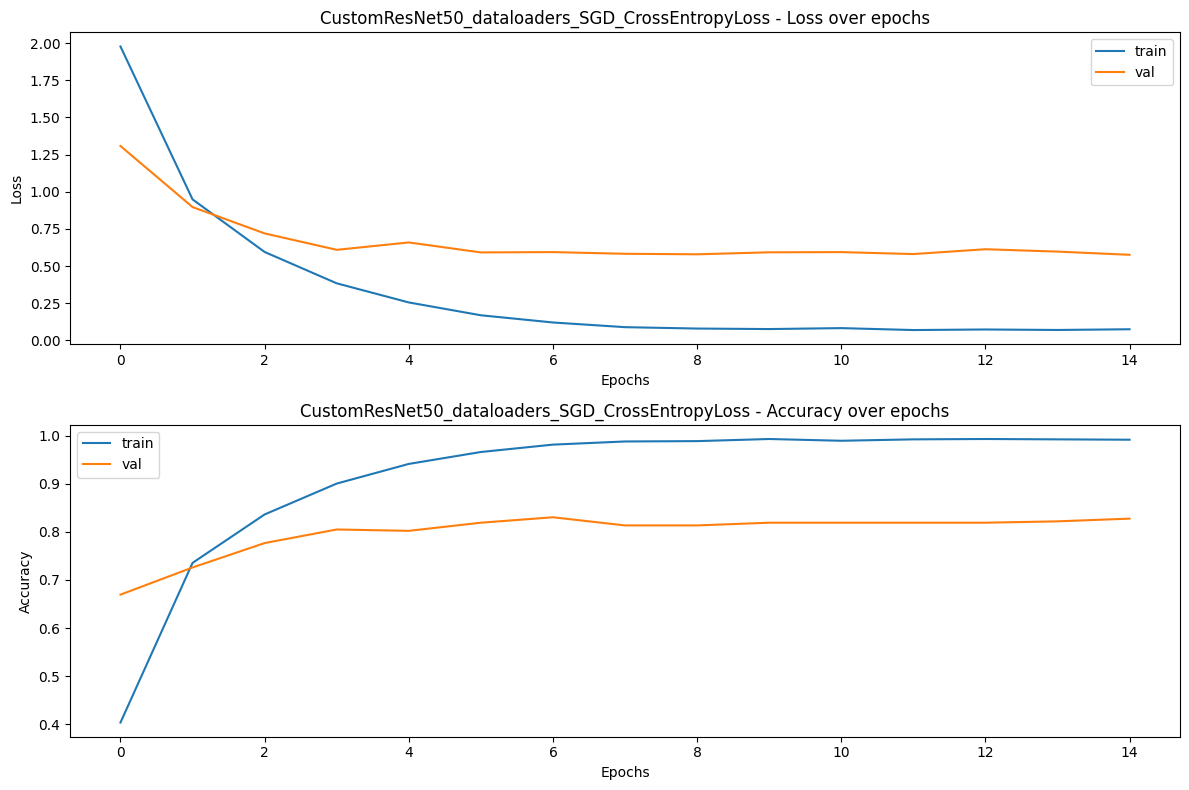


Training with CustomResNet50, dataloaders, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.6191 Acc: 0.3587
val Loss: 2.9818 Acc: 0.1864

Epoch 1/14
----------
train Loss: 1.1464 Acc: 0.4646
val Loss: 1.1239 Acc: 0.4915

Epoch 2/14
----------
train Loss: 0.9288 Acc: 0.5464
val Loss: 3.6499 Acc: 0.2768

Epoch 3/14
----------
train Loss: 0.7476 Acc: 0.5946
val Loss: 4.0506 Acc: 0.3220

Epoch 4/14
----------
train Loss: 0.6702 Acc: 0.6172
val Loss: 1.0811 Acc: 0.5254

Epoch 5/14
----------
train Loss: 0.5583 Acc: 0.6720
val Loss: 0.7443 Acc: 0.5989

Epoch 6/14
----------
train Loss: 0.4819 Acc: 0.7173
val Loss: 1.4578 Acc: 0.4887

Epoch 7/14
----------
train Loss: 0.3950 Acc: 0.7597
val Loss: 0.6026 Acc: 0.7006

Epoch 8/14
----------
train Loss: 0.3055 Acc: 0.8101
val Loss: 0.5640 Acc: 0.6949

Epoch 9/14
----------
train Loss: 0.2641 Acc: 0.8342
val Loss: 0.5538 Acc: 0.7119

Epoch 10/14
----------
train Loss: 0.2345 Acc: 0.8495
val Loss: 0.5413 Acc: 0.7090

Epoch 11/14
----------
tra

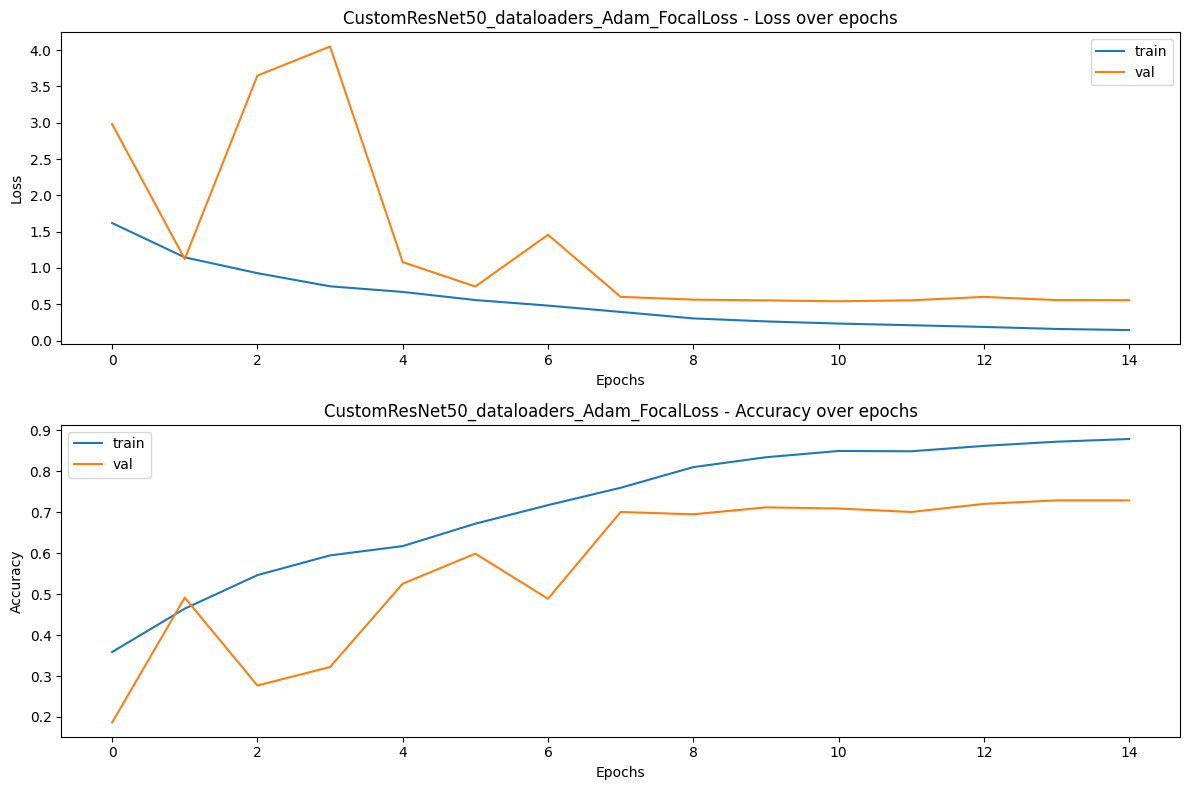


Training with CustomResNet50, dataloaders, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0578 Acc: 0.3528
val Loss: 18.4928 Acc: 0.1412

Epoch 1/14
----------
train Loss: 1.5032 Acc: 0.4821
val Loss: 2.3991 Acc: 0.3672

Epoch 2/14
----------
train Loss: 1.2920 Acc: 0.5573
val Loss: 1.7773 Acc: 0.4407

Epoch 3/14
----------
train Loss: 1.2342 Acc: 0.5603
val Loss: 1.7202 Acc: 0.4492

Epoch 4/14
----------
train Loss: 1.0236 Acc: 0.6384
val Loss: 1.2884 Acc: 0.5706

Epoch 5/14
----------
train Loss: 0.9205 Acc: 0.6684
val Loss: 1.3998 Acc: 0.5819

Epoch 6/14
----------
train Loss: 0.8573 Acc: 0.7137
val Loss: 1.2324 Acc: 0.6073

Epoch 7/14
----------
train Loss: 0.5927 Acc: 0.7962
val Loss: 0.9058 Acc: 0.7119

Epoch 8/14
----------
train Loss: 0.5044 Acc: 0.8400
val Loss: 0.8319 Acc: 0.7486

Epoch 9/14
----------
train Loss: 0.4657 Acc: 0.8430
val Loss: 0.8771 Acc: 0.7373

Epoch 10/14
----------
train Loss: 0.4166 Acc: 0.8641
val Loss: 0.8416 Acc: 0.7514

Epoch 11/14
------

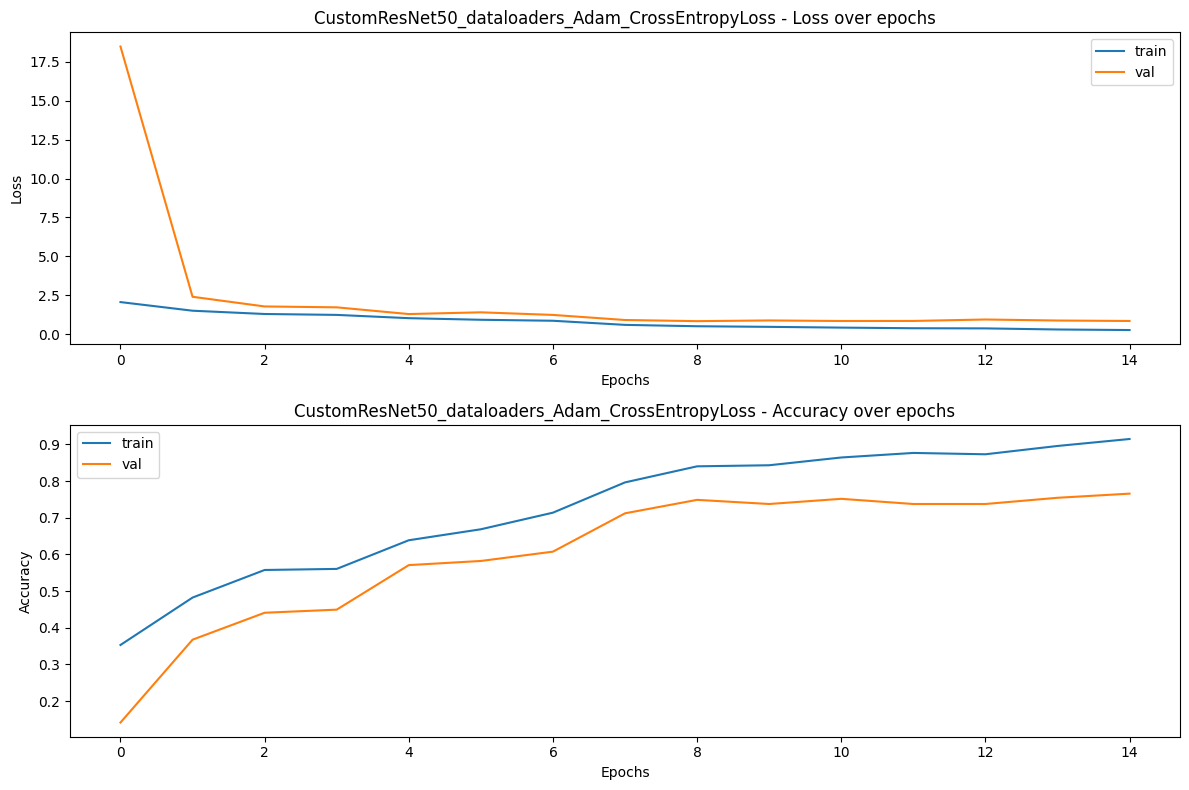


Training with CustomResNet50, dataloaders2, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.5688 Acc: 0.4112
val Loss: 0.8741 Acc: 0.6102

Epoch 1/14
----------
train Loss: 0.6189 Acc: 0.7297
val Loss: 0.5536 Acc: 0.7147

Epoch 2/14
----------
train Loss: 0.3621 Acc: 0.8196
val Loss: 0.4660 Acc: 0.7429

Epoch 3/14
----------
train Loss: 0.2471 Acc: 0.8641
val Loss: 0.4307 Acc: 0.7712

Epoch 4/14
----------
train Loss: 0.1726 Acc: 0.9014
val Loss: 0.3857 Acc: 0.7994

Epoch 5/14
----------
train Loss: 0.1218 Acc: 0.9328
val Loss: 0.3992 Acc: 0.7881

Epoch 6/14
----------
train Loss: 0.0858 Acc: 0.9562
val Loss: 0.3804 Acc: 0.8051

Epoch 7/14
----------
train Loss: 0.0594 Acc: 0.9744
val Loss: 0.3681 Acc: 0.8079

Epoch 8/14
----------
train Loss: 0.0495 Acc: 0.9788
val Loss: 0.3756 Acc: 0.7966

Epoch 9/14
----------
train Loss: 0.0516 Acc: 0.9795
val Loss: 0.3685 Acc: 0.8051

Epoch 10/14
----------
train Loss: 0.0493 Acc: 0.9788
val Loss: 0.3704 Acc: 0.8051

Epoch 11/14
----------
tra

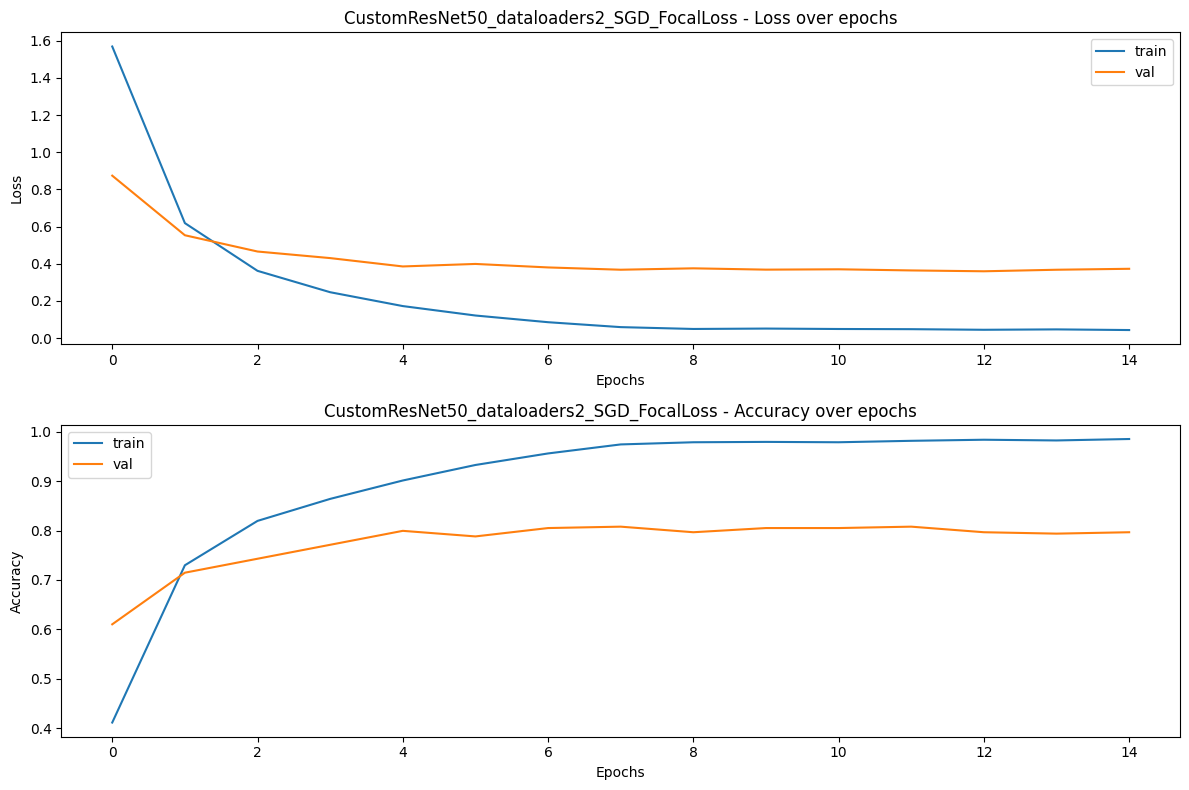


Training with CustomResNet50, dataloaders2, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.0937 Acc: 0.3543
val Loss: 1.3307 Acc: 0.6610

Epoch 1/14
----------
train Loss: 1.0359 Acc: 0.7100
val Loss: 0.8860 Acc: 0.7486

Epoch 2/14
----------
train Loss: 0.6635 Acc: 0.8035
val Loss: 0.7718 Acc: 0.7429

Epoch 3/14
----------
train Loss: 0.4801 Acc: 0.8583
val Loss: 0.7116 Acc: 0.7684

Epoch 4/14
----------
train Loss: 0.3554 Acc: 0.8868
val Loss: 0.6174 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.2706 Acc: 0.9167
val Loss: 0.5619 Acc: 0.8164

Epoch 6/14
----------
train Loss: 0.2019 Acc: 0.9423
val Loss: 0.5784 Acc: 0.8192

Epoch 7/14
----------
train Loss: 0.1534 Acc: 0.9686
val Loss: 0.5662 Acc: 0.8249

Epoch 8/14
----------
train Loss: 0.1368 Acc: 0.9774
val Loss: 0.5602 Acc: 0.8220

Epoch 9/14
----------
train Loss: 0.1275 Acc: 0.9795
val Loss: 0.5374 Acc: 0.8192

Epoch 10/14
----------
train Loss: 0.1225 Acc: 0.9825
val Loss: 0.5425 Acc: 0.8220

Epoch 11/14
-------

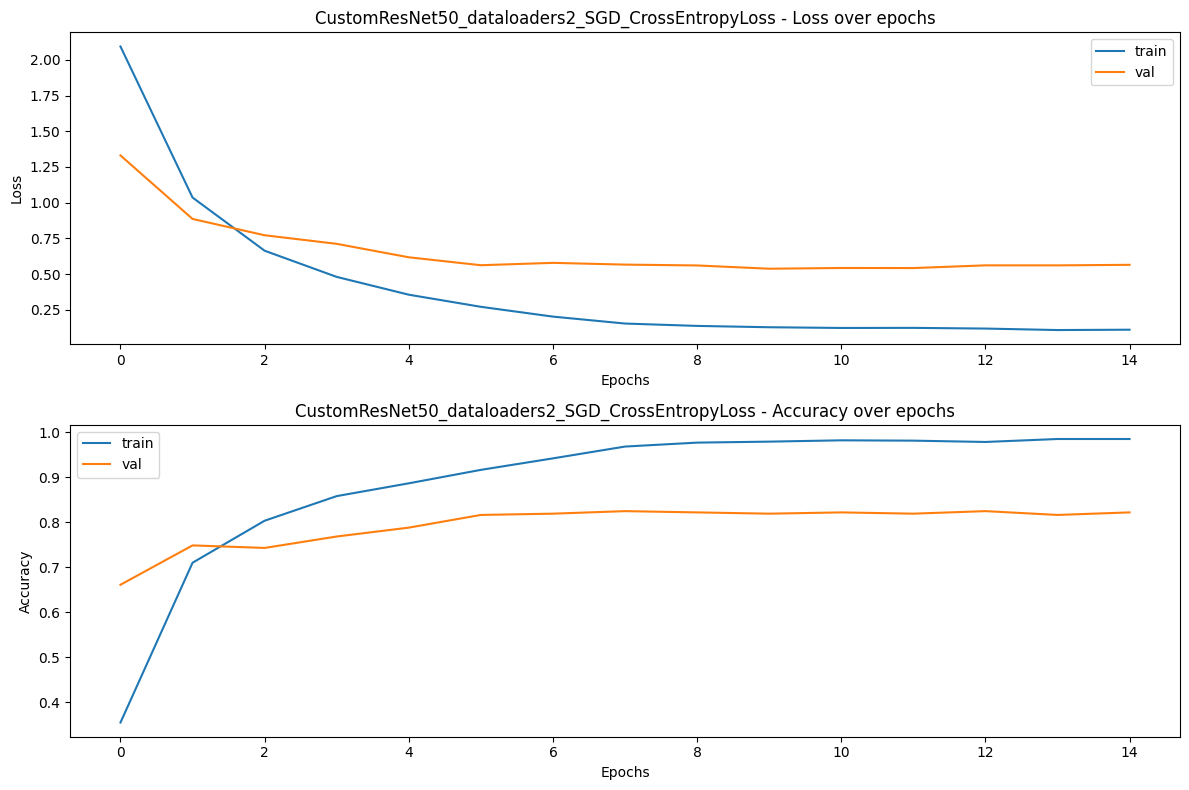


Training with CustomResNet50, dataloaders2, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.4963 Acc: 0.3579
val Loss: 1.7090 Acc: 0.3729

Epoch 1/14
----------
train Loss: 0.9774 Acc: 0.4901
val Loss: 2.1913 Acc: 0.3644

Epoch 2/14
----------
train Loss: 0.8371 Acc: 0.5661
val Loss: 1.0367 Acc: 0.5311

Epoch 3/14
----------
train Loss: 0.6930 Acc: 0.6333
val Loss: 0.7877 Acc: 0.6271

Epoch 4/14
----------
train Loss: 0.6006 Acc: 0.6684
val Loss: 1.2966 Acc: 0.5339

Epoch 5/14
----------
train Loss: 0.5388 Acc: 0.6954
val Loss: 1.0474 Acc: 0.5678

Epoch 6/14
----------
train Loss: 0.5236 Acc: 0.6917
val Loss: 1.1767 Acc: 0.5678

Epoch 7/14
----------
train Loss: 0.3175 Acc: 0.8152
val Loss: 0.6201 Acc: 0.7034

Epoch 8/14
----------
train Loss: 0.2319 Acc: 0.8422
val Loss: 0.5860 Acc: 0.7090

Epoch 9/14
----------
train Loss: 0.2019 Acc: 0.8627
val Loss: 0.5584 Acc: 0.7147

Epoch 10/14
----------
train Loss: 0.1717 Acc: 0.8736
val Loss: 0.5439 Acc: 0.7288

Epoch 11/14
----------
tr

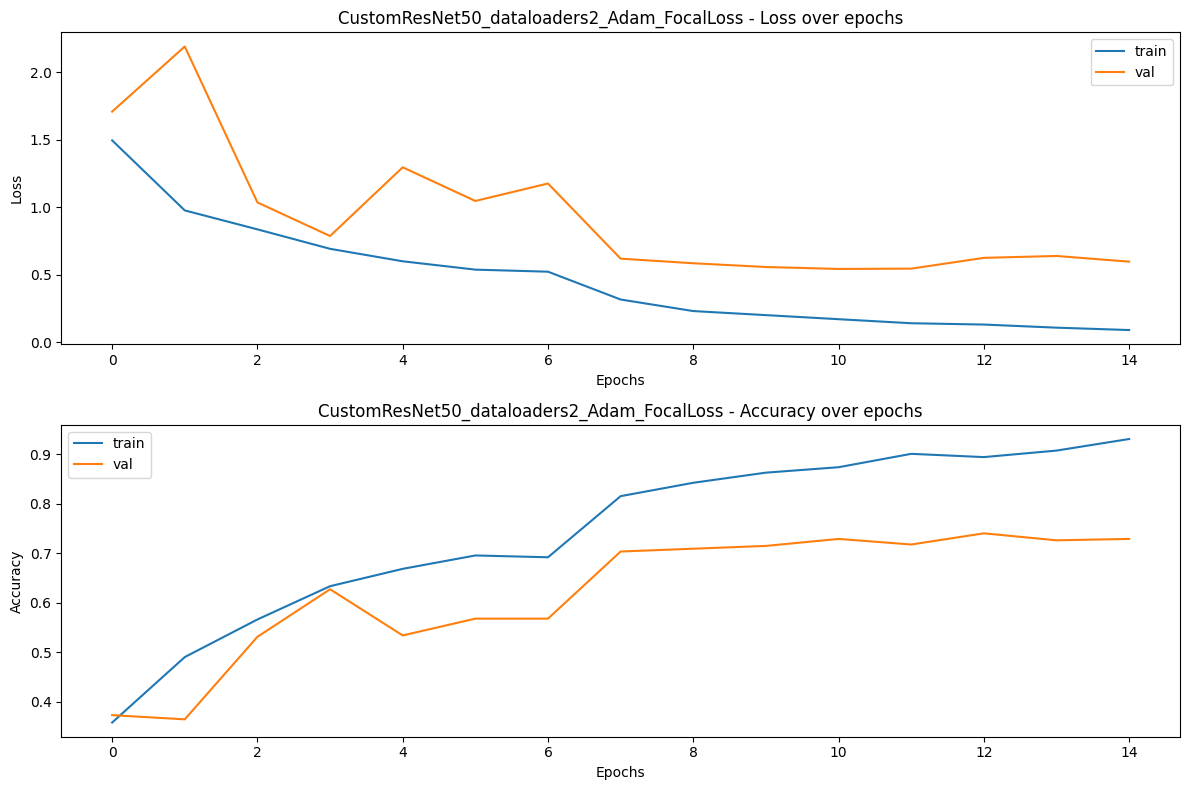


Training with CustomResNet50, dataloaders2, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.8081 Acc: 0.4193
val Loss: 3.9686 Acc: 0.3729

Epoch 1/14
----------
train Loss: 1.2798 Acc: 0.5698
val Loss: 11.0426 Acc: 0.1723

Epoch 2/14
----------
train Loss: 1.1411 Acc: 0.6245
val Loss: 1.5007 Acc: 0.5565

Epoch 3/14
----------
train Loss: 1.0061 Acc: 0.6465
val Loss: 3.9192 Acc: 0.2853

Epoch 4/14
----------
train Loss: 0.9338 Acc: 0.6917
val Loss: 2.6910 Acc: 0.4237

Epoch 5/14
----------
train Loss: 0.7866 Acc: 0.7327
val Loss: 1.1909 Acc: 0.6441

Epoch 6/14
----------
train Loss: 0.7987 Acc: 0.7151
val Loss: 1.2388 Acc: 0.5989

Epoch 7/14
----------
train Loss: 0.4718 Acc: 0.8356
val Loss: 0.8213 Acc: 0.7203

Epoch 8/14
----------
train Loss: 0.4005 Acc: 0.8729
val Loss: 0.7769 Acc: 0.7486

Epoch 9/14
----------
train Loss: 0.3461 Acc: 0.8860
val Loss: 0.7525 Acc: 0.7655

Epoch 10/14
----------
train Loss: 0.3116 Acc: 0.8970
val Loss: 0.7455 Acc: 0.7768

Epoch 11/14
-----

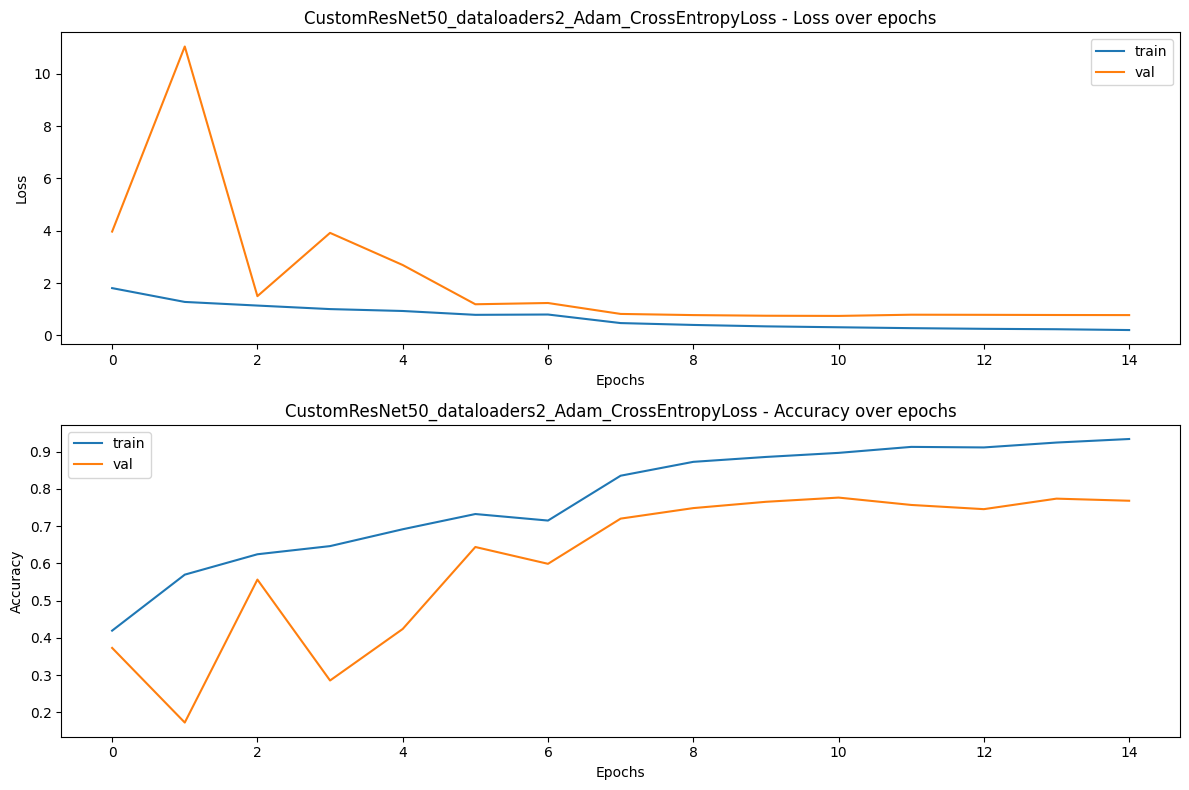


Training with CustomResNet50b, dataloaders, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.0897 Acc: 0.2235
val Loss: 1.6146 Acc: 0.4153

Epoch 1/14
----------
train Loss: 1.1576 Acc: 0.5844
val Loss: 0.8416 Acc: 0.6751

Epoch 2/14
----------
train Loss: 0.6081 Acc: 0.7385
val Loss: 0.6217 Acc: 0.7373

Epoch 3/14
----------
train Loss: 0.3582 Acc: 0.8232
val Loss: 0.4986 Acc: 0.7458

Epoch 4/14
----------
train Loss: 0.2381 Acc: 0.8700
val Loss: 0.4361 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.1752 Acc: 0.8970
val Loss: 0.4241 Acc: 0.7910

Epoch 6/14
----------
train Loss: 0.1191 Acc: 0.9386
val Loss: 0.4278 Acc: 0.7910

Epoch 7/14
----------
train Loss: 0.0851 Acc: 0.9657
val Loss: 0.4145 Acc: 0.7994

Epoch 8/14
----------
train Loss: 0.0756 Acc: 0.9635
val Loss: 0.3995 Acc: 0.8023

Epoch 9/14
----------
train Loss: 0.0719 Acc: 0.9693
val Loss: 0.4001 Acc: 0.8136

Epoch 10/14
----------
train Loss: 0.0699 Acc: 0.9693
val Loss: 0.4047 Acc: 0.7994

Epoch 11/14
----------
tra

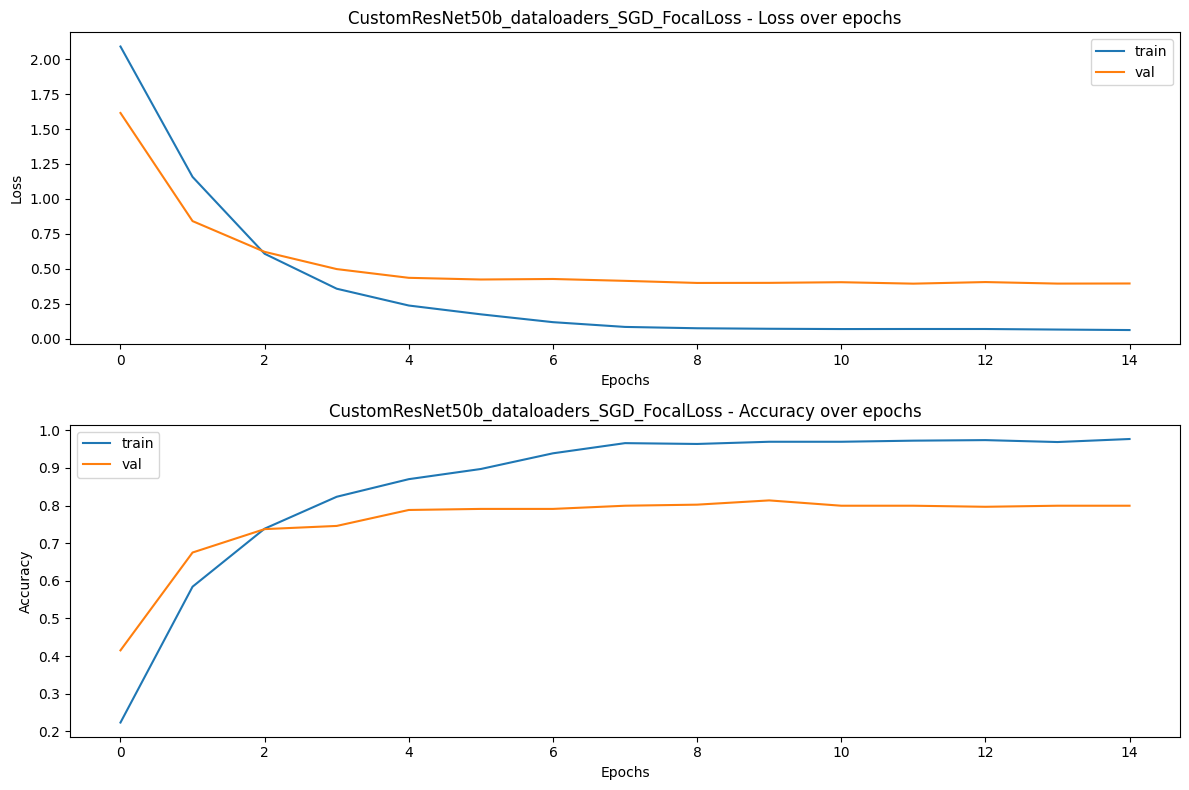


Training with CustomResNet50b, dataloaders, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5189 Acc: 0.2279
val Loss: 2.0865 Acc: 0.3814

Epoch 1/14
----------
train Loss: 1.6908 Acc: 0.5033
val Loss: 1.4058 Acc: 0.5734

Epoch 2/14
----------
train Loss: 1.0886 Acc: 0.6866
val Loss: 1.0256 Acc: 0.7090

Epoch 3/14
----------
train Loss: 0.7407 Acc: 0.8050
val Loss: 0.7858 Acc: 0.7684

Epoch 4/14
----------
train Loss: 0.5238 Acc: 0.8524
val Loss: 0.7544 Acc: 0.7571

Epoch 5/14
----------
train Loss: 0.3600 Acc: 0.8963
val Loss: 0.6143 Acc: 0.8164

Epoch 6/14
----------
train Loss: 0.3012 Acc: 0.9014
val Loss: 0.6028 Acc: 0.8023

Epoch 7/14
----------
train Loss: 0.2209 Acc: 0.9401
val Loss: 0.5732 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.2172 Acc: 0.9372
val Loss: 0.5774 Acc: 0.8277

Epoch 9/14
----------
train Loss: 0.2079 Acc: 0.9511
val Loss: 0.5702 Acc: 0.8277

Epoch 10/14
----------
train Loss: 0.2064 Acc: 0.9569
val Loss: 0.5832 Acc: 0.8164

Epoch 11/14
-------

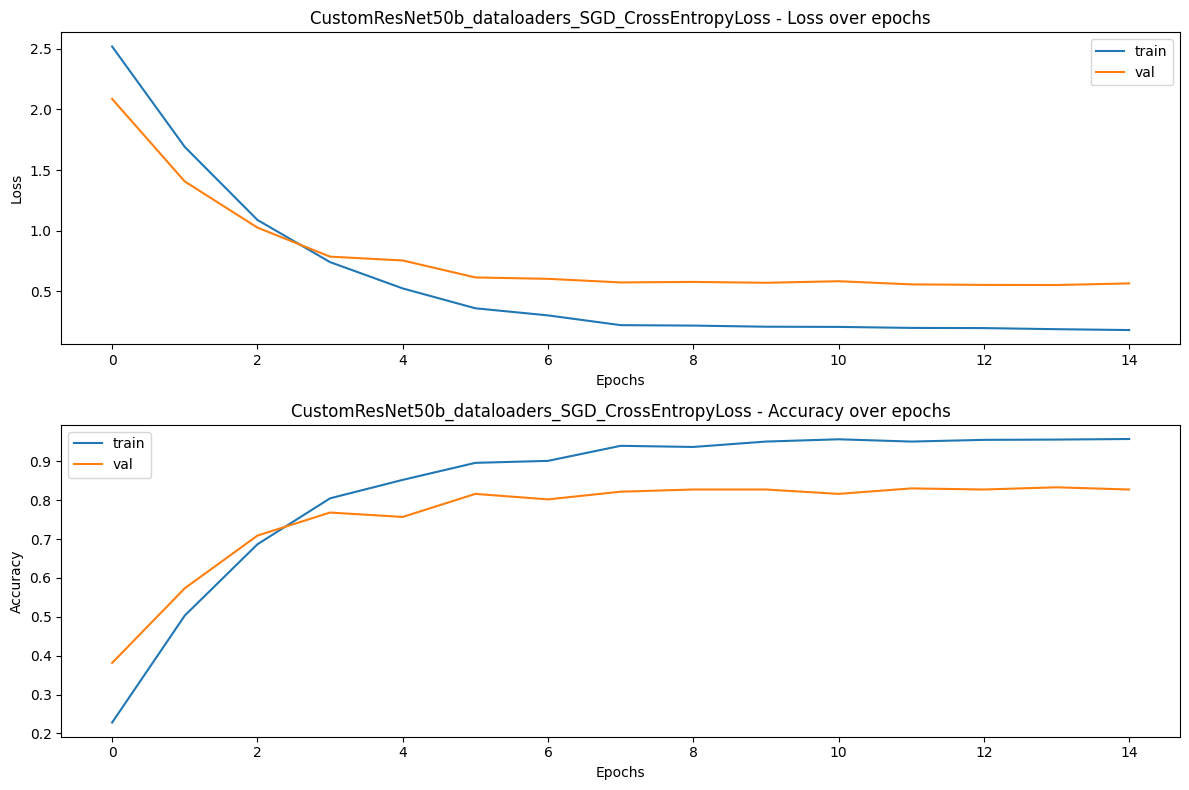


Training with CustomResNet50b, dataloaders, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.5728 Acc: 0.3404
val Loss: 1.7951 Acc: 0.2712

Epoch 1/14
----------
train Loss: 0.9897 Acc: 0.4887
val Loss: 1.3527 Acc: 0.4576

Epoch 2/14
----------
train Loss: 0.8112 Acc: 0.5676
val Loss: 1.1294 Acc: 0.5000

Epoch 3/14
----------
train Loss: 0.7373 Acc: 0.5924
val Loss: 1.0039 Acc: 0.4944

Epoch 4/14
----------
train Loss: 0.6406 Acc: 0.6275
val Loss: 0.8634 Acc: 0.5593

Epoch 5/14
----------
train Loss: 0.5794 Acc: 0.6406
val Loss: 1.1254 Acc: 0.5000

Epoch 6/14
----------
train Loss: 0.5686 Acc: 0.6486
val Loss: 1.3459 Acc: 0.4859

Epoch 7/14
----------
train Loss: 0.3862 Acc: 0.7421
val Loss: 0.7618 Acc: 0.6215

Epoch 8/14
----------
train Loss: 0.3191 Acc: 0.7765
val Loss: 0.7234 Acc: 0.6356

Epoch 9/14
----------
train Loss: 0.2640 Acc: 0.8057
val Loss: 0.6770 Acc: 0.6356

Epoch 10/14
----------
train Loss: 0.2496 Acc: 0.8028
val Loss: 0.8166 Acc: 0.6186

Epoch 11/14
----------
tr

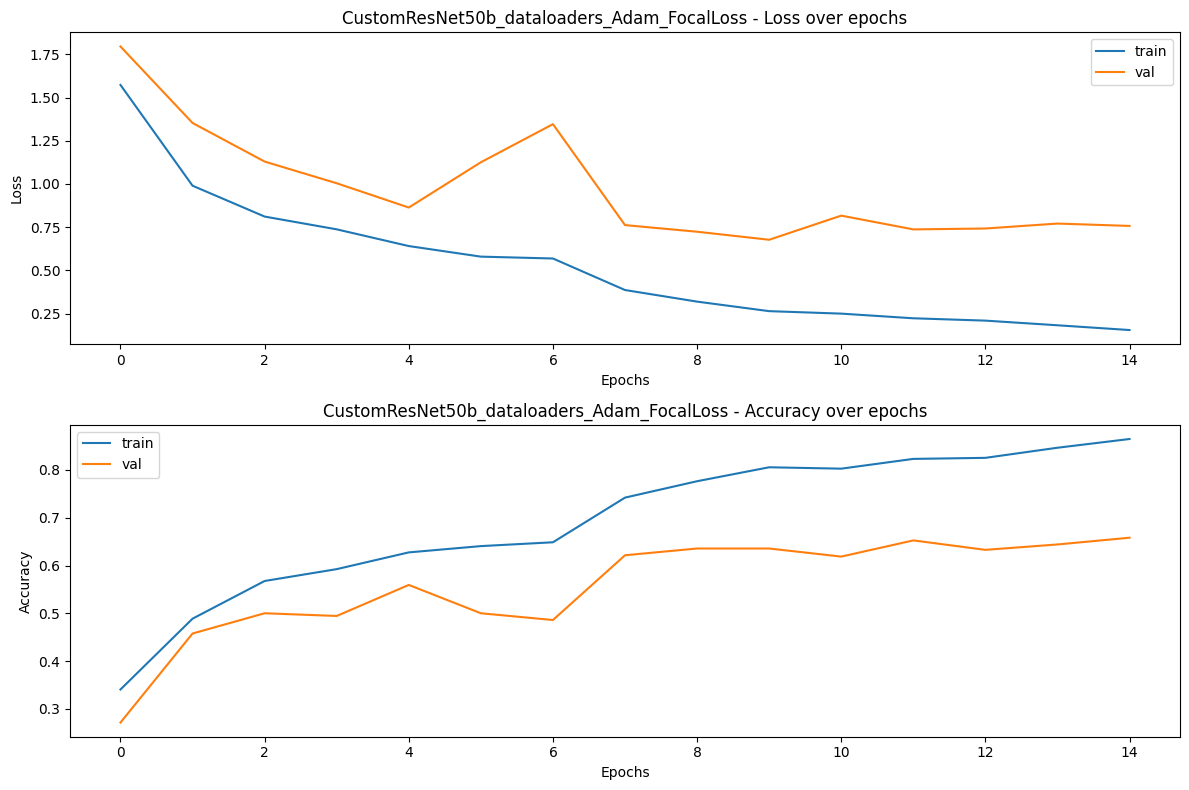


Training with CustomResNet50b, dataloaders, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9136 Acc: 0.3674
val Loss: 98.6252 Acc: 0.1384

Epoch 1/14
----------
train Loss: 1.5538 Acc: 0.4872
val Loss: 1.8055 Acc: 0.4407

Epoch 2/14
----------
train Loss: 1.2860 Acc: 0.5500
val Loss: 1.8327 Acc: 0.4322

Epoch 3/14
----------
train Loss: 1.0787 Acc: 0.6026
val Loss: 1.8292 Acc: 0.5367

Epoch 4/14
----------
train Loss: 1.0255 Acc: 0.6392
val Loss: 1.9117 Acc: 0.4802

Epoch 5/14
----------
train Loss: 0.9306 Acc: 0.6859
val Loss: 1.4161 Acc: 0.5085

Epoch 6/14
----------
train Loss: 0.8925 Acc: 0.6888
val Loss: 2.1600 Acc: 0.4802

Epoch 7/14
----------
train Loss: 0.7199 Acc: 0.7604
val Loss: 0.9877 Acc: 0.6808

Epoch 8/14
----------
train Loss: 0.6269 Acc: 0.7728
val Loss: 0.9476 Acc: 0.6836

Epoch 9/14
----------
train Loss: 0.5451 Acc: 0.8130
val Loss: 0.9500 Acc: 0.7034

Epoch 10/14
----------
train Loss: 0.5302 Acc: 0.8020
val Loss: 0.9463 Acc: 0.6893

Epoch 11/14
-----

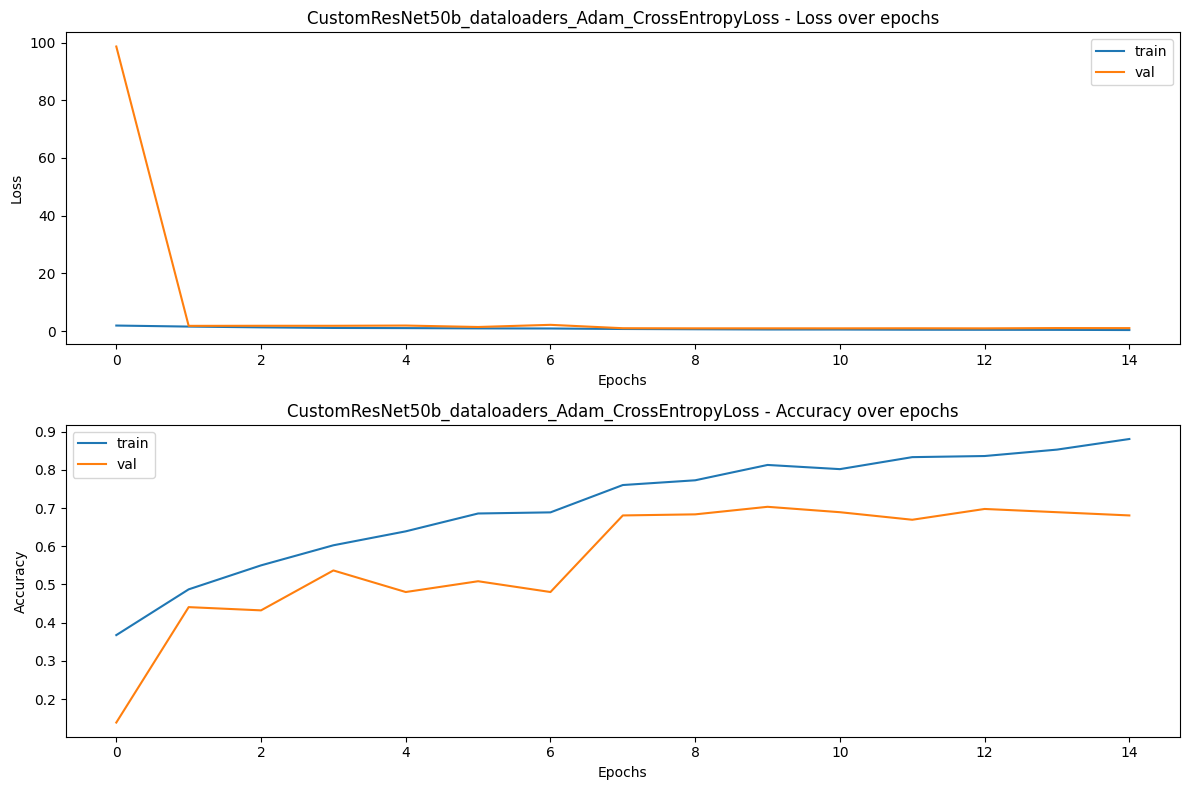


Training with CustomResNet50b, dataloaders2, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 2.1206 Acc: 0.2096
val Loss: 1.6186 Acc: 0.3446

Epoch 1/14
----------
train Loss: 1.1936 Acc: 0.5310
val Loss: 0.8737 Acc: 0.5932

Epoch 2/14
----------
train Loss: 0.6524 Acc: 0.7071
val Loss: 0.6285 Acc: 0.7062

Epoch 3/14
----------
train Loss: 0.4553 Acc: 0.7699
val Loss: 0.5219 Acc: 0.7288

Epoch 4/14
----------
train Loss: 0.3198 Acc: 0.8378
val Loss: 0.4536 Acc: 0.7768

Epoch 5/14
----------
train Loss: 0.2397 Acc: 0.8598
val Loss: 0.4123 Acc: 0.7966

Epoch 6/14
----------
train Loss: 0.1849 Acc: 0.9072
val Loss: 0.4428 Acc: 0.7740

Epoch 7/14
----------
train Loss: 0.1324 Acc: 0.9248
val Loss: 0.3706 Acc: 0.8051

Epoch 8/14
----------
train Loss: 0.1289 Acc: 0.9379
val Loss: 0.3722 Acc: 0.8107

Epoch 9/14
----------
train Loss: 0.1263 Acc: 0.9401
val Loss: 0.3782 Acc: 0.8079

Epoch 10/14
----------
train Loss: 0.1126 Acc: 0.9445
val Loss: 0.3832 Acc: 0.7966

Epoch 11/14
----------
tr

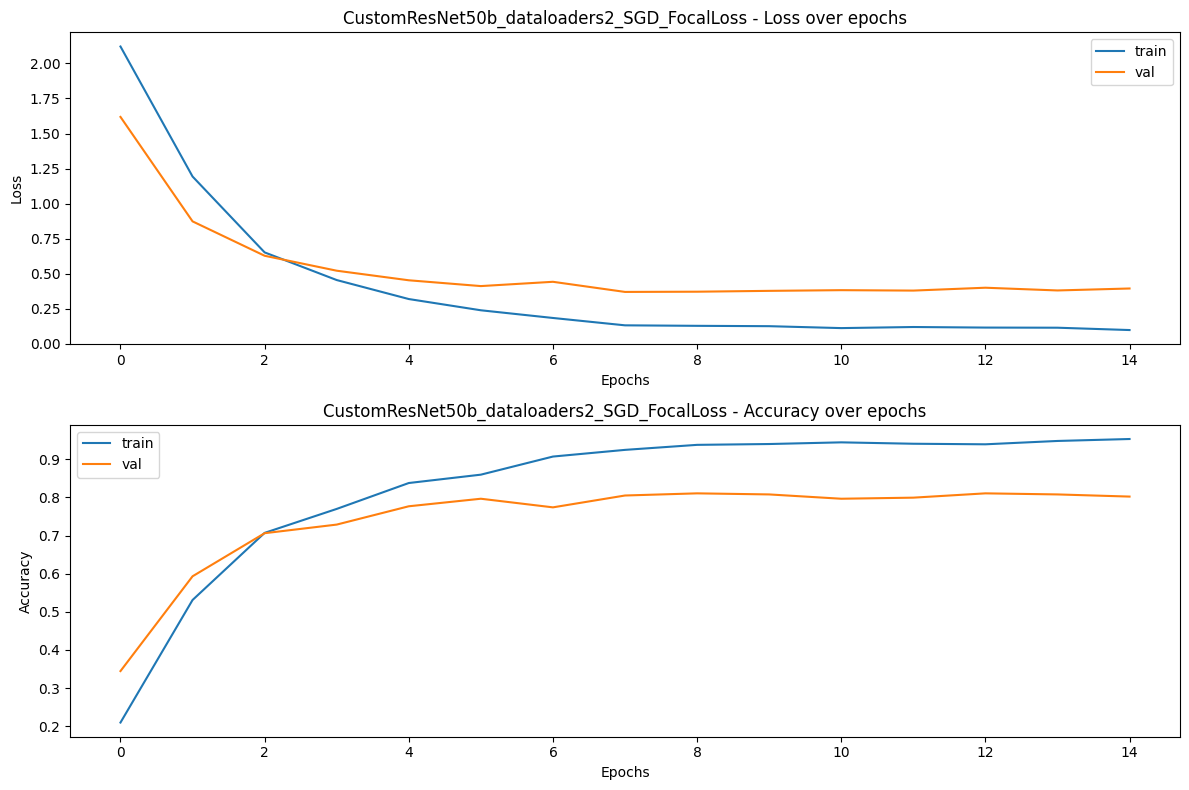


Training with CustomResNet50b, dataloaders2, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.5419 Acc: 0.2118
val Loss: 2.1587 Acc: 0.3136

Epoch 1/14
----------
train Loss: 1.8227 Acc: 0.4624
val Loss: 1.4655 Acc: 0.5932

Epoch 2/14
----------
train Loss: 1.2164 Acc: 0.6523
val Loss: 1.0993 Acc: 0.6667

Epoch 3/14
----------
train Loss: 0.8469 Acc: 0.7619
val Loss: 0.8519 Acc: 0.7514

Epoch 4/14
----------
train Loss: 0.6769 Acc: 0.8028
val Loss: 0.7850 Acc: 0.7373

Epoch 5/14
----------
train Loss: 0.5021 Acc: 0.8510
val Loss: 0.6684 Acc: 0.7938

Epoch 6/14
----------
train Loss: 0.3950 Acc: 0.8882
val Loss: 0.6810 Acc: 0.7881

Epoch 7/14
----------
train Loss: 0.3005 Acc: 0.9226
val Loss: 0.6643 Acc: 0.7825

Epoch 8/14
----------
train Loss: 0.3095 Acc: 0.9123
val Loss: 0.6487 Acc: 0.7881

Epoch 9/14
----------
train Loss: 0.2709 Acc: 0.9313
val Loss: 0.6542 Acc: 0.7910

Epoch 10/14
----------
train Loss: 0.2632 Acc: 0.9277
val Loss: 0.6382 Acc: 0.7881

Epoch 11/14
------

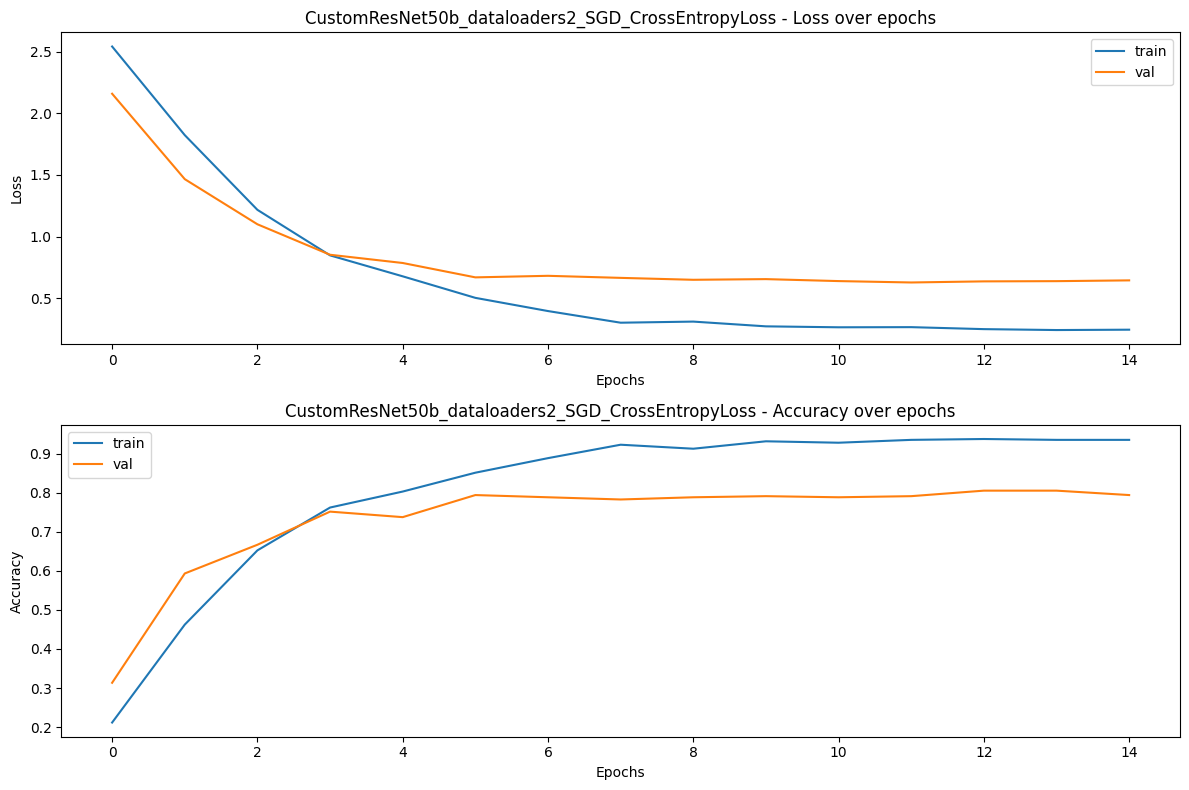


Training with CustomResNet50b, dataloaders2, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.8121 Acc: 0.2418
val Loss: 1.6869 Acc: 0.2571

Epoch 1/14
----------
train Loss: 1.3161 Acc: 0.3440
val Loss: 1.6247 Acc: 0.2966

Epoch 2/14
----------
train Loss: 1.0766 Acc: 0.4200
val Loss: 1.0164 Acc: 0.4294

Epoch 3/14
----------
train Loss: 0.9500 Acc: 0.4909
val Loss: 1.6464 Acc: 0.2684

Epoch 4/14
----------
train Loss: 0.8705 Acc: 0.5245
val Loss: 1.7524 Acc: 0.2881

Epoch 5/14
----------
train Loss: 0.7796 Acc: 0.5354
val Loss: 0.9671 Acc: 0.5085

Epoch 6/14
----------
train Loss: 0.6829 Acc: 0.5705
val Loss: 0.8905 Acc: 0.5395

Epoch 7/14
----------
train Loss: 0.5123 Acc: 0.6574
val Loss: 0.6971 Acc: 0.5876

Epoch 8/14
----------
train Loss: 0.4484 Acc: 0.6888
val Loss: 0.6892 Acc: 0.5960

Epoch 9/14
----------
train Loss: 0.4338 Acc: 0.6881
val Loss: 0.6995 Acc: 0.5876

Epoch 10/14
----------
train Loss: 0.3890 Acc: 0.7027
val Loss: 0.6757 Acc: 0.5989

Epoch 11/14
----------
t

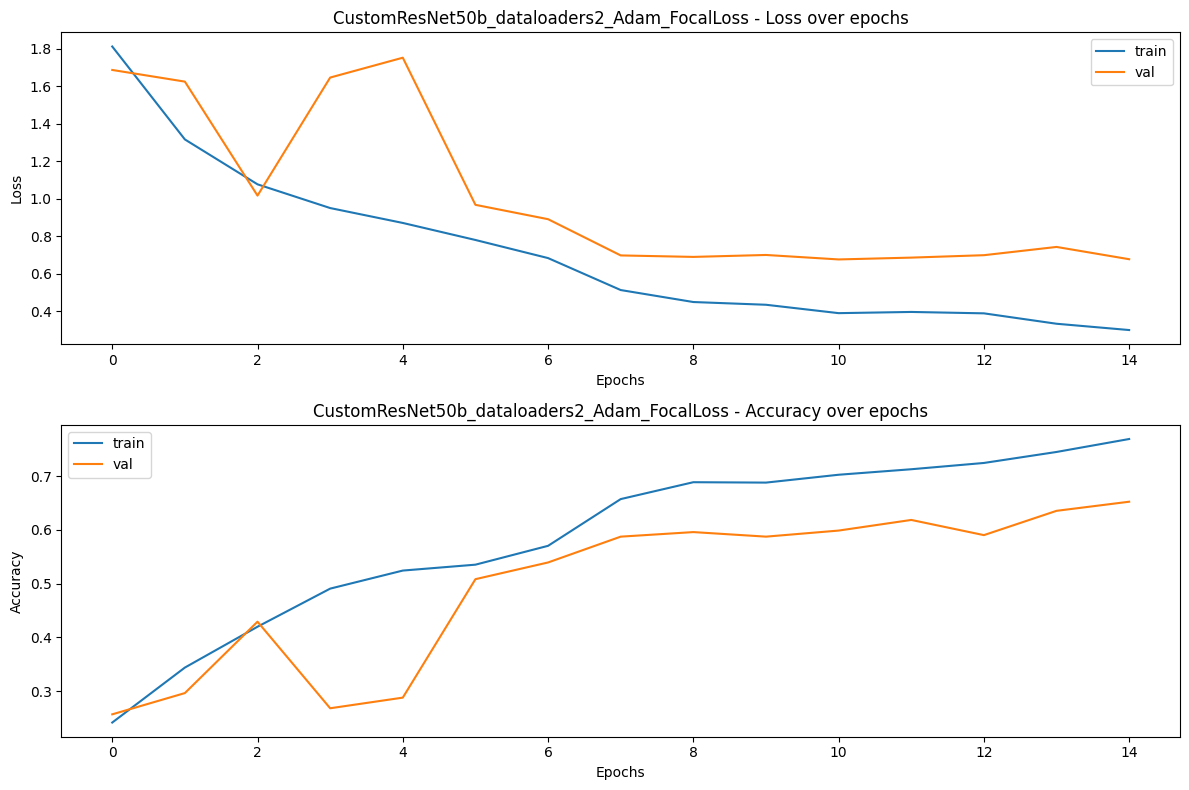


Training with CustomResNet50b, dataloaders2, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 2.1542 Acc: 0.2805
val Loss: 2.5991 Acc: 0.2147

Epoch 1/14
----------
train Loss: 1.6047 Acc: 0.4302
val Loss: 1.9127 Acc: 0.3814

Epoch 2/14
----------
train Loss: 1.4824 Acc: 0.4850
val Loss: 2.1410 Acc: 0.3757

Epoch 3/14
----------
train Loss: 1.3021 Acc: 0.5172
val Loss: 2.0668 Acc: 0.4379

Epoch 4/14
----------
train Loss: 1.1750 Acc: 0.5698
val Loss: 1.4721 Acc: 0.5113

Epoch 5/14
----------
train Loss: 1.0907 Acc: 0.5858
val Loss: 1.3260 Acc: 0.5169

Epoch 6/14
----------
train Loss: 1.0205 Acc: 0.6121
val Loss: 3.1106 Acc: 0.3672

Epoch 7/14
----------
train Loss: 0.8610 Acc: 0.6837
val Loss: 1.0402 Acc: 0.6158

Epoch 8/14
----------
train Loss: 0.7472 Acc: 0.7268
val Loss: 1.0574 Acc: 0.6130

Epoch 9/14
----------
train Loss: 0.7131 Acc: 0.7378
val Loss: 1.0902 Acc: 0.6102

Epoch 10/14
----------
train Loss: 0.6697 Acc: 0.7538
val Loss: 1.0362 Acc: 0.6356

Epoch 11/14
-----

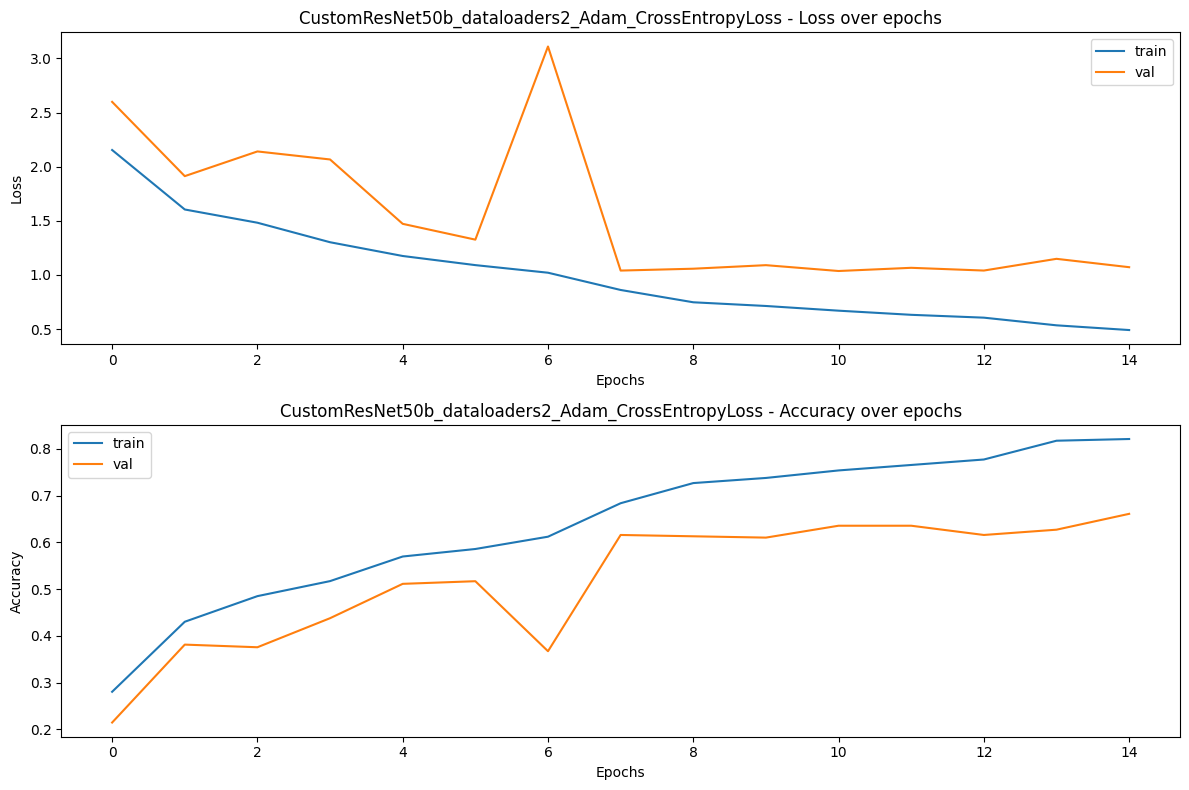


Training with CustomDenseNet, dataloaders, SGD, FocalLoss


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 39.7MB/s]


Epoch 0/14
----------
train Loss: 1.4238 Acc: 0.4478
val Loss: 0.7402 Acc: 0.6808

Epoch 1/14
----------
train Loss: 0.4650 Acc: 0.7874
val Loss: 0.4933 Acc: 0.7655

Epoch 2/14
----------
train Loss: 0.2715 Acc: 0.8561
val Loss: 0.4509 Acc: 0.7825

Epoch 3/14
----------
train Loss: 0.1440 Acc: 0.9284
val Loss: 0.3871 Acc: 0.7797

Epoch 4/14
----------
train Loss: 0.0911 Acc: 0.9576
val Loss: 0.3899 Acc: 0.8023

Epoch 5/14
----------
train Loss: 0.0543 Acc: 0.9876
val Loss: 0.3498 Acc: 0.8249

Epoch 6/14
----------
train Loss: 0.0384 Acc: 0.9912
val Loss: 0.3556 Acc: 0.8107

Epoch 7/14
----------
train Loss: 0.0348 Acc: 0.9905
val Loss: 0.3529 Acc: 0.8249

Epoch 8/14
----------
train Loss: 0.0344 Acc: 0.9912
val Loss: 0.3430 Acc: 0.8249

Epoch 9/14
----------
train Loss: 0.0297 Acc: 0.9949
val Loss: 0.3645 Acc: 0.8249

Epoch 10/14
----------
train Loss: 0.0267 Acc: 0.9956
val Loss: 0.3574 Acc: 0.8192

Epoch 11/14
----------
train Loss: 0.0239 Acc: 0.9971
val Loss: 0.3570 Acc: 0.8079

Ep

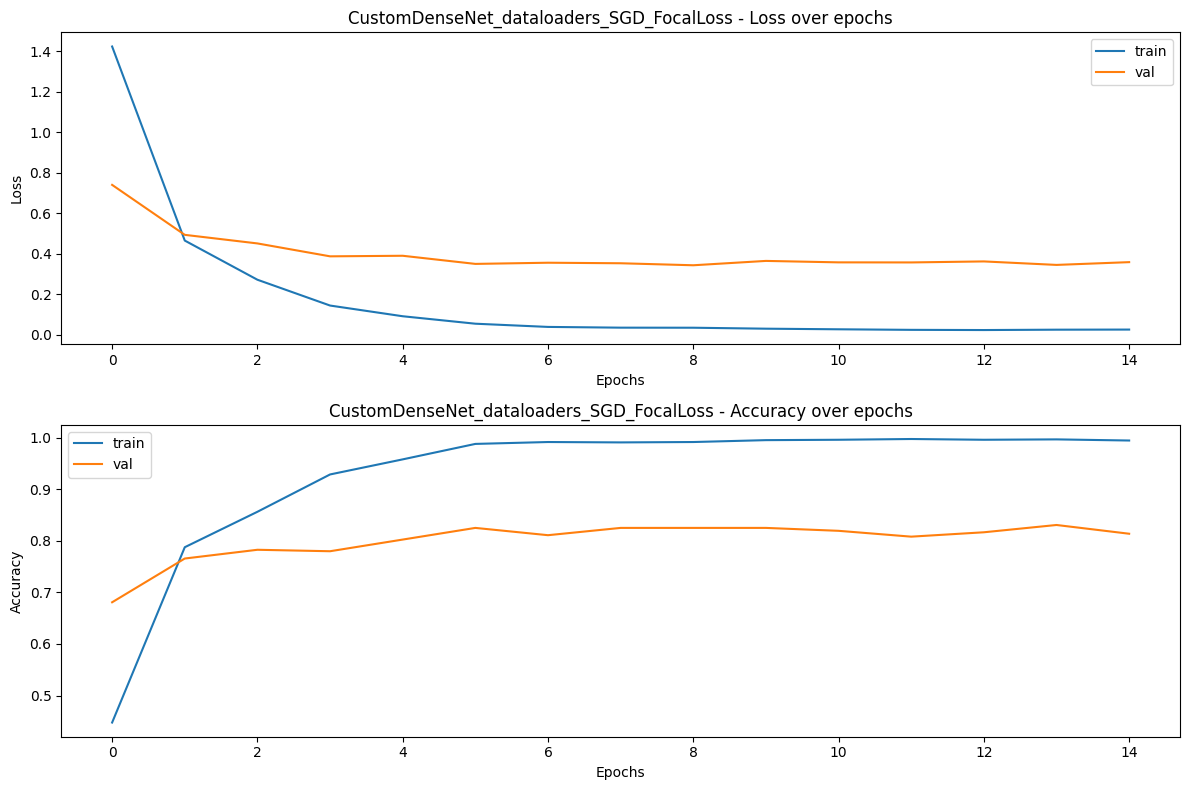


Training with CustomDenseNet, dataloaders, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.8534 Acc: 0.4741
val Loss: 1.1815 Acc: 0.6667

Epoch 1/14
----------
train Loss: 0.8348 Acc: 0.7809
val Loss: 0.8430 Acc: 0.7429

Epoch 2/14
----------
train Loss: 0.5043 Acc: 0.8605
val Loss: 0.6302 Acc: 0.7966

Epoch 3/14
----------
train Loss: 0.3324 Acc: 0.9196
val Loss: 0.6048 Acc: 0.8107

Epoch 4/14
----------
train Loss: 0.2207 Acc: 0.9525
val Loss: 0.5441 Acc: 0.8192

Epoch 5/14
----------
train Loss: 0.1782 Acc: 0.9657
val Loss: 0.5835 Acc: 0.8277

Epoch 6/14
----------
train Loss: 0.1279 Acc: 0.9781
val Loss: 0.5375 Acc: 0.8362

Epoch 7/14
----------
train Loss: 0.0874 Acc: 0.9927
val Loss: 0.5211 Acc: 0.8475

Epoch 8/14
----------
train Loss: 0.0808 Acc: 0.9912
val Loss: 0.5243 Acc: 0.8418

Epoch 9/14
----------
train Loss: 0.0815 Acc: 0.9927
val Loss: 0.5171 Acc: 0.8531

Epoch 10/14
----------
train Loss: 0.0693 Acc: 0.9934
val Loss: 0.5049 Acc: 0.8390

Epoch 11/14
--------

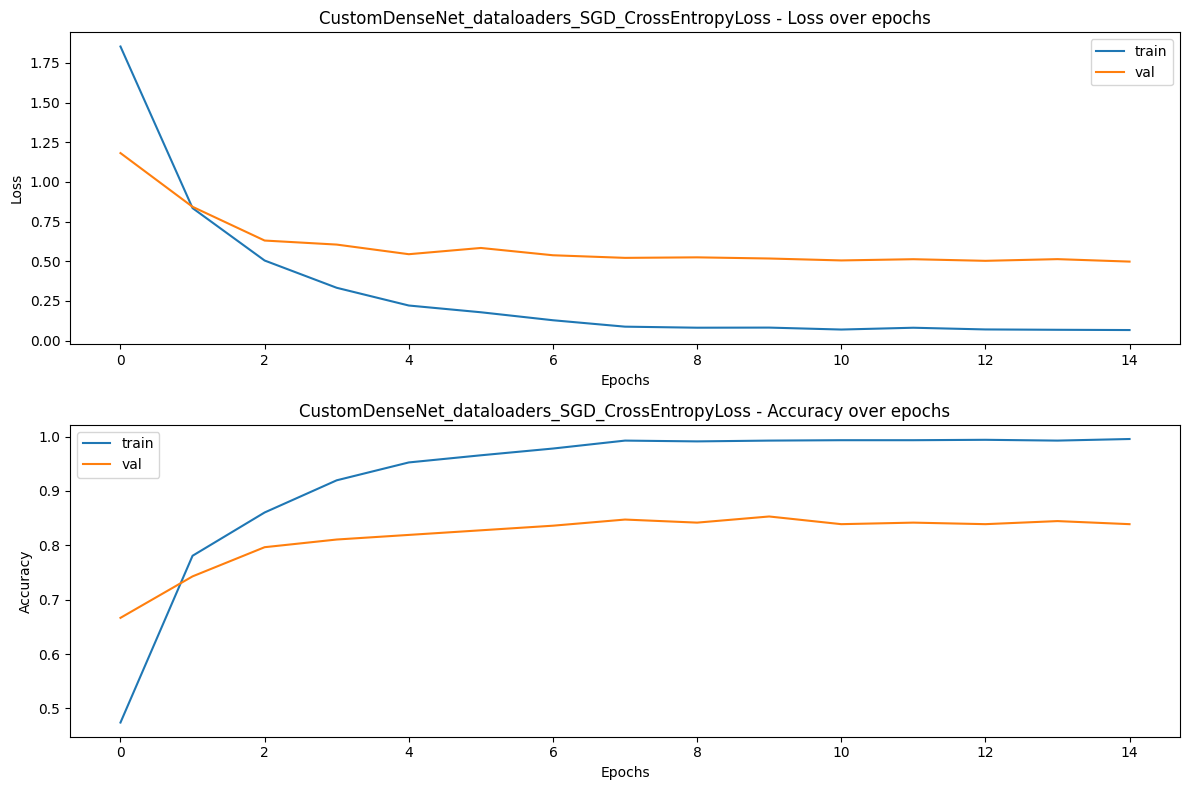


Training with CustomDenseNet, dataloaders, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.8922 Acc: 0.6172
val Loss: 1.0803 Acc: 0.5650

Epoch 1/14
----------
train Loss: 0.5066 Acc: 0.7275
val Loss: 0.6323 Acc: 0.6949

Epoch 2/14
----------
train Loss: 0.3479 Acc: 0.7860
val Loss: 1.0521 Acc: 0.6186

Epoch 3/14
----------
train Loss: 0.2465 Acc: 0.8408
val Loss: 0.6401 Acc: 0.7232

Epoch 4/14
----------
train Loss: 0.2260 Acc: 0.8554
val Loss: 0.6099 Acc: 0.7316

Epoch 5/14
----------
train Loss: 0.1624 Acc: 0.8860
val Loss: 0.6870 Acc: 0.6751

Epoch 6/14
----------
train Loss: 0.1952 Acc: 0.8736
val Loss: 0.5958 Acc: 0.7458

Epoch 7/14
----------
train Loss: 0.1032 Acc: 0.9226
val Loss: 0.2818 Acc: 0.8559

Epoch 8/14
----------
train Loss: 0.0425 Acc: 0.9649
val Loss: 0.2734 Acc: 0.8672

Epoch 9/14
----------
train Loss: 0.0264 Acc: 0.9752
val Loss: 0.2665 Acc: 0.8503

Epoch 10/14
----------
train Loss: 0.0232 Acc: 0.9832
val Loss: 0.2661 Acc: 0.8729

Epoch 11/14
----------
tra

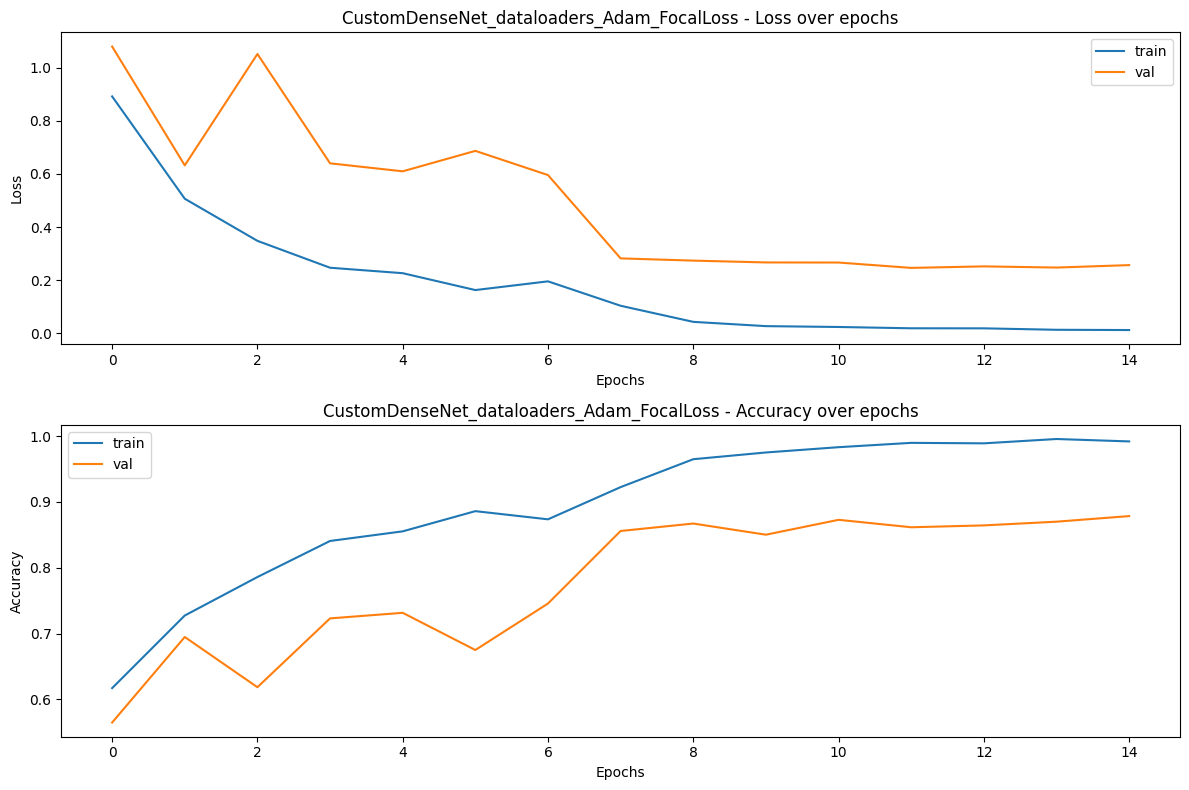


Training with CustomDenseNet, dataloaders, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.2203 Acc: 0.6034
val Loss: 1.2649 Acc: 0.6554

Epoch 1/14
----------
train Loss: 0.7460 Acc: 0.7714
val Loss: 1.9484 Acc: 0.5254

Epoch 2/14
----------
train Loss: 0.6034 Acc: 0.8137
val Loss: 0.9619 Acc: 0.7203

Epoch 3/14
----------
train Loss: 0.5049 Acc: 0.8283
val Loss: 1.4101 Acc: 0.6271

Epoch 4/14
----------
train Loss: 0.3881 Acc: 0.8685
val Loss: 0.8301 Acc: 0.7938

Epoch 5/14
----------
train Loss: 0.2961 Acc: 0.9043
val Loss: 0.6442 Acc: 0.8079

Epoch 6/14
----------
train Loss: 0.2918 Acc: 0.8999
val Loss: 0.7704 Acc: 0.7768

Epoch 7/14
----------
train Loss: 0.1672 Acc: 0.9503
val Loss: 0.5742 Acc: 0.8390

Epoch 8/14
----------
train Loss: 0.1162 Acc: 0.9657
val Loss: 0.5531 Acc: 0.8446

Epoch 9/14
----------
train Loss: 0.0825 Acc: 0.9839
val Loss: 0.5263 Acc: 0.8531

Epoch 10/14
----------
train Loss: 0.0718 Acc: 0.9847
val Loss: 0.5034 Acc: 0.8644

Epoch 11/14
-------

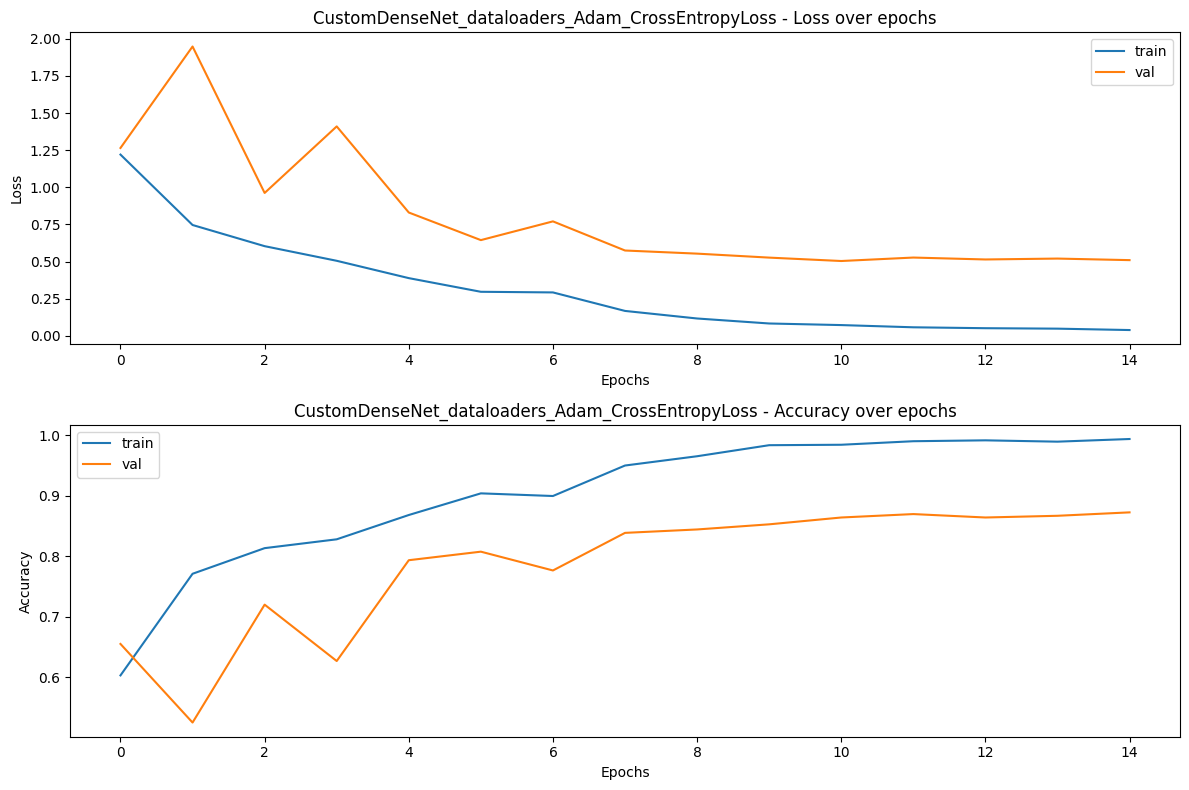


Training with CustomDenseNet, dataloaders2, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4540 Acc: 0.4390
val Loss: 0.7549 Acc: 0.6695

Epoch 1/14
----------
train Loss: 0.5487 Acc: 0.7516
val Loss: 0.5427 Acc: 0.7288

Epoch 2/14
----------
train Loss: 0.3346 Acc: 0.8283
val Loss: 0.4692 Acc: 0.7514

Epoch 3/14
----------
train Loss: 0.2417 Acc: 0.8678
val Loss: 0.4173 Acc: 0.7910

Epoch 4/14
----------
train Loss: 0.1751 Acc: 0.8904
val Loss: 0.4090 Acc: 0.7825

Epoch 5/14
----------
train Loss: 0.1323 Acc: 0.9226
val Loss: 0.3702 Acc: 0.8136

Epoch 6/14
----------
train Loss: 0.0773 Acc: 0.9584
val Loss: 0.3790 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.0648 Acc: 0.9664
val Loss: 0.3618 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.0634 Acc: 0.9693
val Loss: 0.3465 Acc: 0.8277

Epoch 9/14
----------
train Loss: 0.0589 Acc: 0.9766
val Loss: 0.3517 Acc: 0.8277

Epoch 10/14
----------
train Loss: 0.0557 Acc: 0.9803
val Loss: 0.3392 Acc: 0.8418

Epoch 11/14
----------
tra

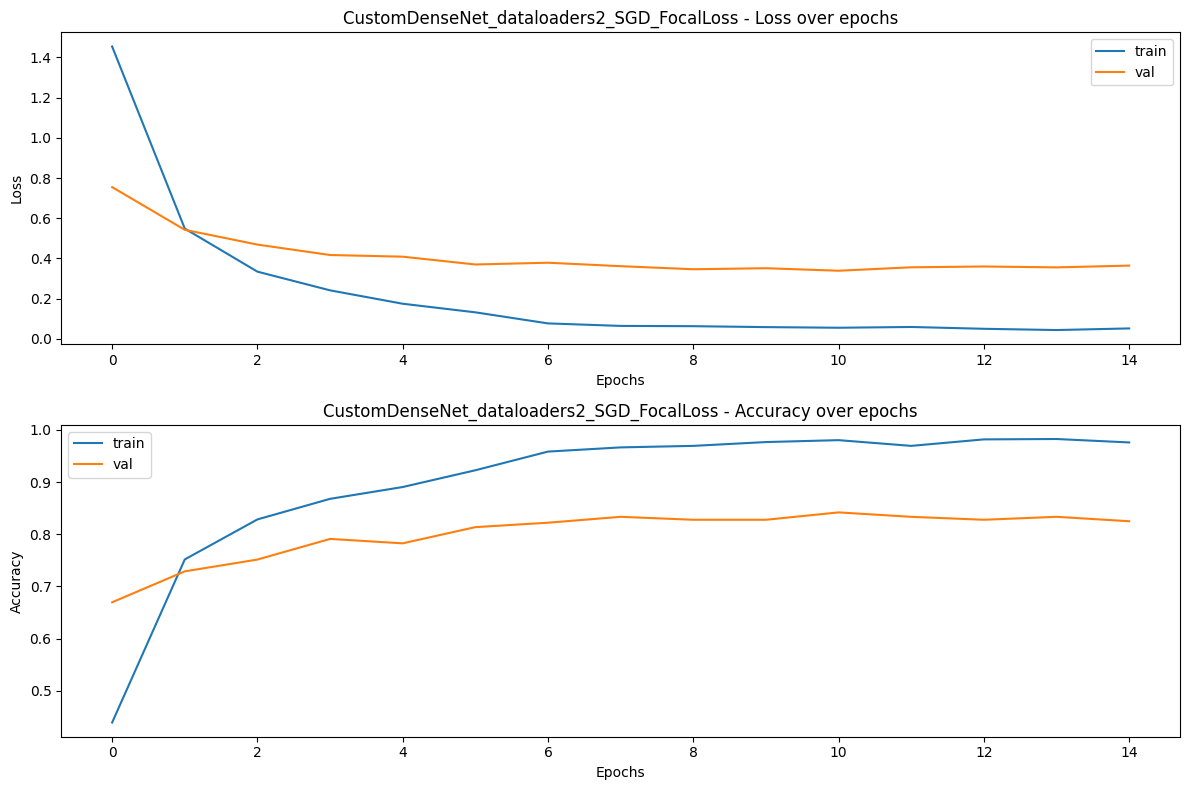


Training with CustomDenseNet, dataloaders2, SGD, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.9175 Acc: 0.4638
val Loss: 1.1847 Acc: 0.6836

Epoch 1/14
----------
train Loss: 0.9599 Acc: 0.7341
val Loss: 0.8520 Acc: 0.7345

Epoch 2/14
----------
train Loss: 0.6545 Acc: 0.8130
val Loss: 0.6985 Acc: 0.7740

Epoch 3/14
----------
train Loss: 0.4733 Acc: 0.8627
val Loss: 0.6399 Acc: 0.8079

Epoch 4/14
----------
train Loss: 0.3348 Acc: 0.9116
val Loss: 0.6080 Acc: 0.7966

Epoch 5/14
----------
train Loss: 0.2568 Acc: 0.9379
val Loss: 0.5503 Acc: 0.8164

Epoch 6/14
----------
train Loss: 0.1902 Acc: 0.9554
val Loss: 0.5782 Acc: 0.8220

Epoch 7/14
----------
train Loss: 0.1440 Acc: 0.9744
val Loss: 0.5456 Acc: 0.8192

Epoch 8/14
----------
train Loss: 0.1352 Acc: 0.9774
val Loss: 0.5321 Acc: 0.8249

Epoch 9/14
----------
train Loss: 0.1381 Acc: 0.9766
val Loss: 0.5448 Acc: 0.8249

Epoch 10/14
----------
train Loss: 0.1252 Acc: 0.9839
val Loss: 0.5342 Acc: 0.8164

Epoch 11/14
-------

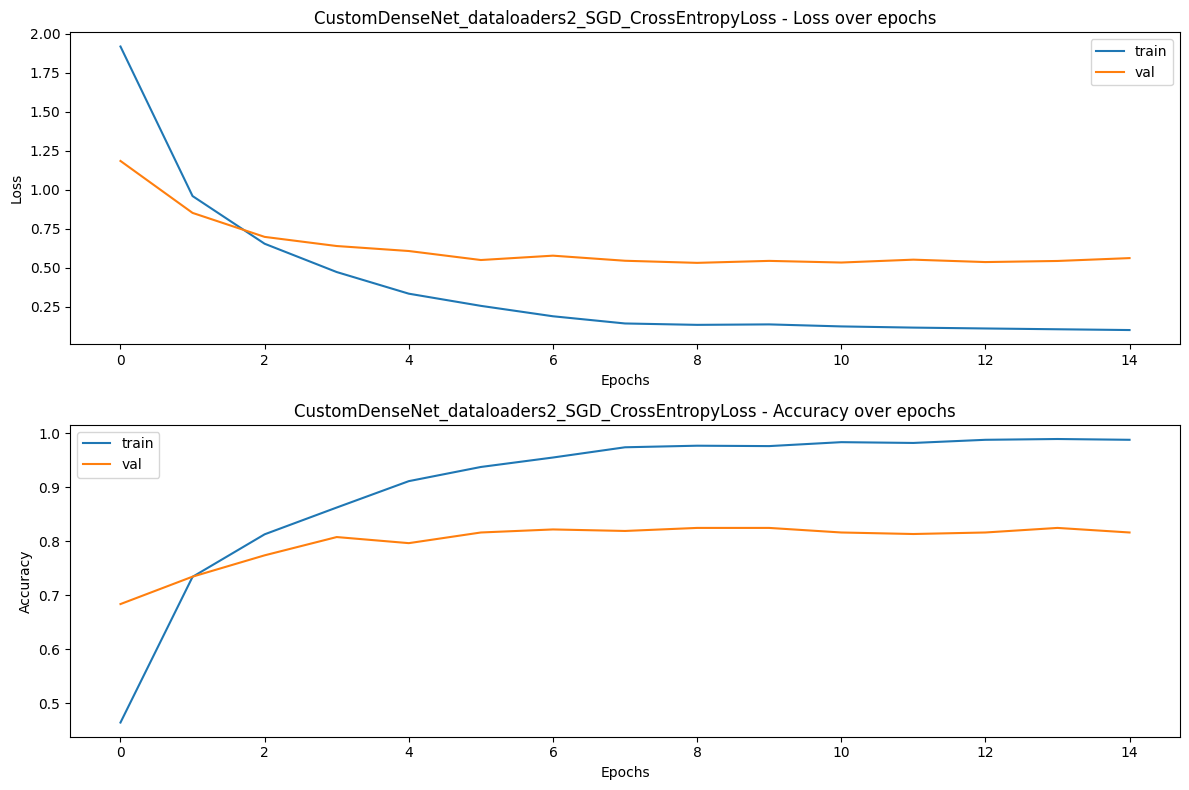


Training with CustomDenseNet, dataloaders2, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9770 Acc: 0.5551
val Loss: 0.6763 Acc: 0.6751

Epoch 1/14
----------
train Loss: 0.5447 Acc: 0.7071
val Loss: 1.4273 Acc: 0.5056

Epoch 2/14
----------
train Loss: 0.4490 Acc: 0.7546
val Loss: 0.6588 Acc: 0.6977

Epoch 3/14
----------
train Loss: 0.3387 Acc: 0.7860
val Loss: 0.8113 Acc: 0.6525

Epoch 4/14
----------
train Loss: 0.2794 Acc: 0.8283
val Loss: 0.6478 Acc: 0.6977

Epoch 5/14
----------
train Loss: 0.2557 Acc: 0.8342
val Loss: 0.4624 Acc: 0.7429

Epoch 6/14
----------
train Loss: 0.1703 Acc: 0.8795
val Loss: 0.5246 Acc: 0.7458

Epoch 7/14
----------
train Loss: 0.1141 Acc: 0.9160
val Loss: 0.3439 Acc: 0.8475

Epoch 8/14
----------
train Loss: 0.0565 Acc: 0.9569
val Loss: 0.3190 Acc: 0.8503

Epoch 9/14
----------
train Loss: 0.0494 Acc: 0.9554
val Loss: 0.3012 Acc: 0.8446

Epoch 10/14
----------
train Loss: 0.0358 Acc: 0.9722
val Loss: 0.2838 Acc: 0.8588

Epoch 11/14
----------
tr

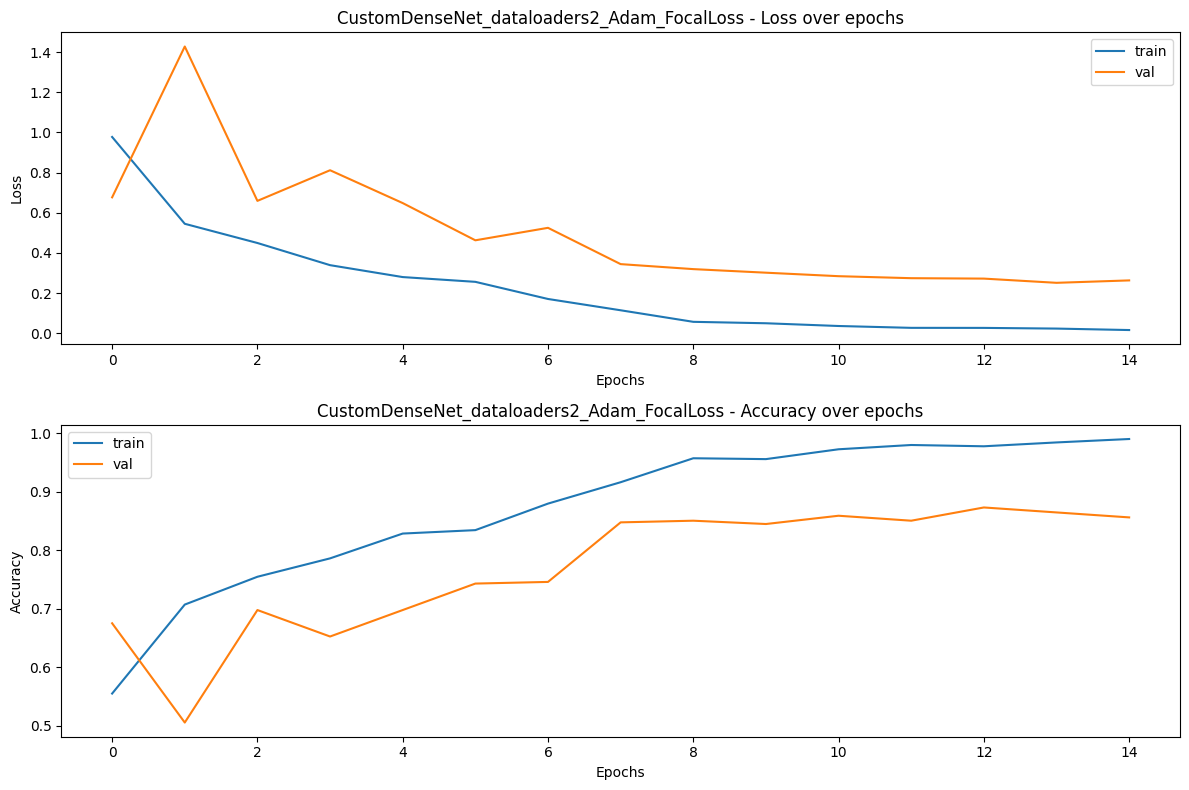


Training with CustomDenseNet, dataloaders2, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.3744 Acc: 0.5793
val Loss: 1.6067 Acc: 0.5056

Epoch 1/14
----------
train Loss: 0.8516 Acc: 0.7327
val Loss: 1.2104 Acc: 0.6328

Epoch 2/14
----------
train Loss: 0.7274 Acc: 0.7589
val Loss: 0.9418 Acc: 0.7203

Epoch 3/14
----------
train Loss: 0.5844 Acc: 0.8013
val Loss: 0.6721 Acc: 0.7712

Epoch 4/14
----------
train Loss: 0.4981 Acc: 0.8364
val Loss: 1.0737 Acc: 0.7147

Epoch 5/14
----------
train Loss: 0.3688 Acc: 0.8714
val Loss: 1.0513 Acc: 0.7147

Epoch 6/14
----------
train Loss: 0.3379 Acc: 0.8780
val Loss: 0.7883 Acc: 0.7797

Epoch 7/14
----------
train Loss: 0.1910 Acc: 0.9489
val Loss: 0.4808 Acc: 0.8644

Epoch 8/14
----------
train Loss: 0.1138 Acc: 0.9759
val Loss: 0.4811 Acc: 0.8644

Epoch 9/14
----------
train Loss: 0.1005 Acc: 0.9759
val Loss: 0.4555 Acc: 0.8729

Epoch 10/14
----------
train Loss: 0.0833 Acc: 0.9839
val Loss: 0.4574 Acc: 0.8842

Epoch 11/14
------

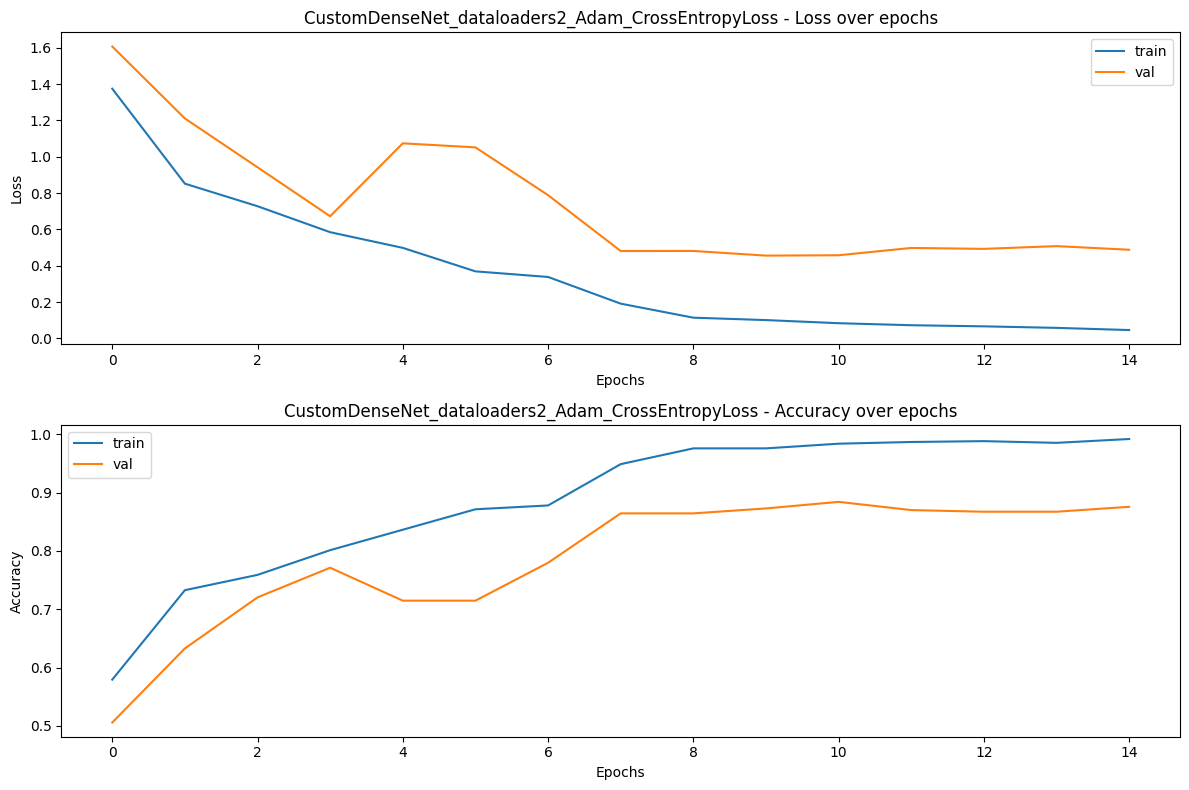

In [12]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy
               

In [13]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.86      0.90      0.88        49
           6       0.88      1.00      0.93        14
           7       0.94      0.94      0.94        18
           8       0.97      1.00      0.99        35
           9       1.00      0.94      0.97        34
          11       1.00      0.95      0.97        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.90      1.00      0.95        19
          16       0.58      0.70      0.64        20
          17       1.00      0.94      0.97        17
          18       0.95      0.95      0.95        22
          19       1.00      0.95      0.97        19
          23       0.48      0.53      0.50        19
          25       0.86   

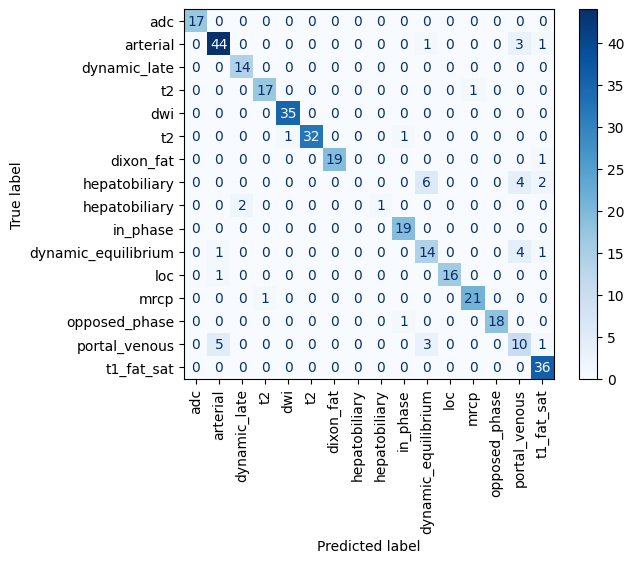

<Figure size 2500x2500 with 0 Axes>

In [14]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


save_filename = f"cnn_model_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_predictions, val_labels, classes, fn=save_filename, saveflag=True)

# Save the trained model if needed

torch.save(trained_model.state_dict(), f'/content/gdrive/MyDrive/{save_filename}')




#Experiment: gamma filter with different hyperparameter#
Looking at applying a gamma filter on the images with two different settings to see if it affects accuracy. One of the key components that a human looks at is the distribution of bright pixels (and how they correspond to different portions of anatomy), so a gamma filter may affect how bright pixels are accentuated in the image. 

In [ ]:
from cnn_


Training with CustomDenseNet, dataloaders3, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0397 Acc: 0.5398
val Loss: 0.9210 Acc: 0.5791

Epoch 1/14
----------
train Loss: 0.5969 Acc: 0.6903
val Loss: 0.6134 Acc: 0.6864

Epoch 2/14
----------
train Loss: 0.4834 Acc: 0.7524
val Loss: 0.8850 Acc: 0.6497

Epoch 3/14
----------
train Loss: 0.3499 Acc: 0.7962
val Loss: 0.5357 Acc: 0.6921

Epoch 4/14
----------
train Loss: 0.2747 Acc: 0.8210
val Loss: 0.6820 Acc: 0.7288

Epoch 5/14
----------
train Loss: 0.2141 Acc: 0.8568
val Loss: 0.6500 Acc: 0.7203

Epoch 6/14
----------
train Loss: 0.2098 Acc: 0.8598
val Loss: 0.6806 Acc: 0.7429

Epoch 7/14
----------
train Loss: 0.1227 Acc: 0.9189
val Loss: 0.3583 Acc: 0.8446

Epoch 8/14
----------
train Loss: 0.0605 Acc: 0.9554
val Loss: 0.3433 Acc: 0.8475

Epoch 9/14
----------
train Loss: 0.0435 Acc: 0.9664
val Loss: 0.3178 Acc: 0.8503

Epoch 10/14
----------
train Loss: 0.0385 Acc: 0.9737
val Loss: 0.3071 Acc: 0.8701

Epoch 11/14
----------
tr

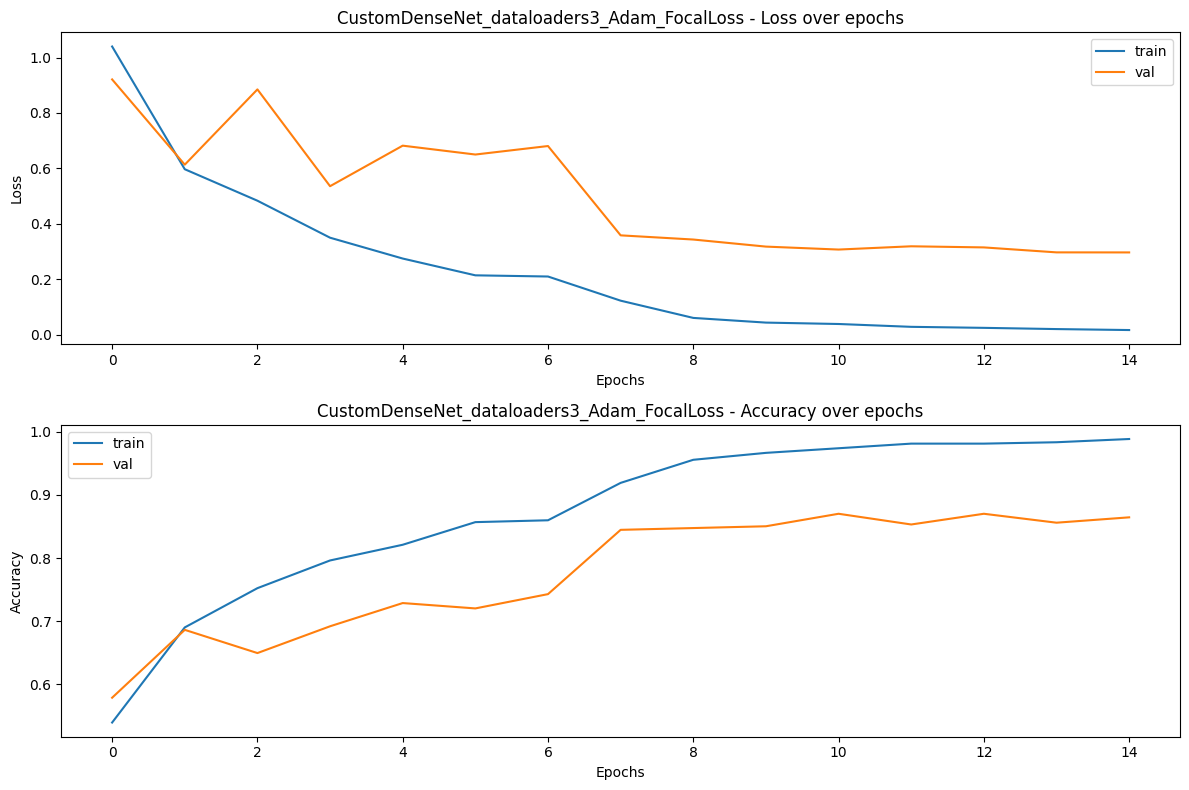


Training with CustomDenseNet, dataloaders4, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0775 Acc: 0.5106
val Loss: 1.4849 Acc: 0.4068

Epoch 1/14
----------
train Loss: 0.6078 Acc: 0.6749
val Loss: 0.8394 Acc: 0.6554

Epoch 2/14
----------
train Loss: 0.4842 Acc: 0.7246
val Loss: 0.8584 Acc: 0.5819

Epoch 3/14
----------
train Loss: 0.3250 Acc: 0.8028
val Loss: 0.9696 Acc: 0.6186

Epoch 4/14
----------
train Loss: 0.3254 Acc: 0.7991
val Loss: 0.8789 Acc: 0.6045

Epoch 5/14
----------
train Loss: 0.3055 Acc: 0.8167
val Loss: 0.7336 Acc: 0.6582

Epoch 6/14
----------
train Loss: 0.2401 Acc: 0.8305
val Loss: 0.6332 Acc: 0.7119

Epoch 7/14
----------
train Loss: 0.1143 Acc: 0.9123
val Loss: 0.3354 Acc: 0.8164

Epoch 8/14
----------
train Loss: 0.0776 Acc: 0.9445
val Loss: 0.2540 Acc: 0.8418

Epoch 9/14
----------
train Loss: 0.0478 Acc: 0.9642
val Loss: 0.2596 Acc: 0.8475

Epoch 10/14
----------
train Loss: 0.0442 Acc: 0.9657
val Loss: 0.2576 Acc: 0.8418

Epoch 11/14
----------
tr

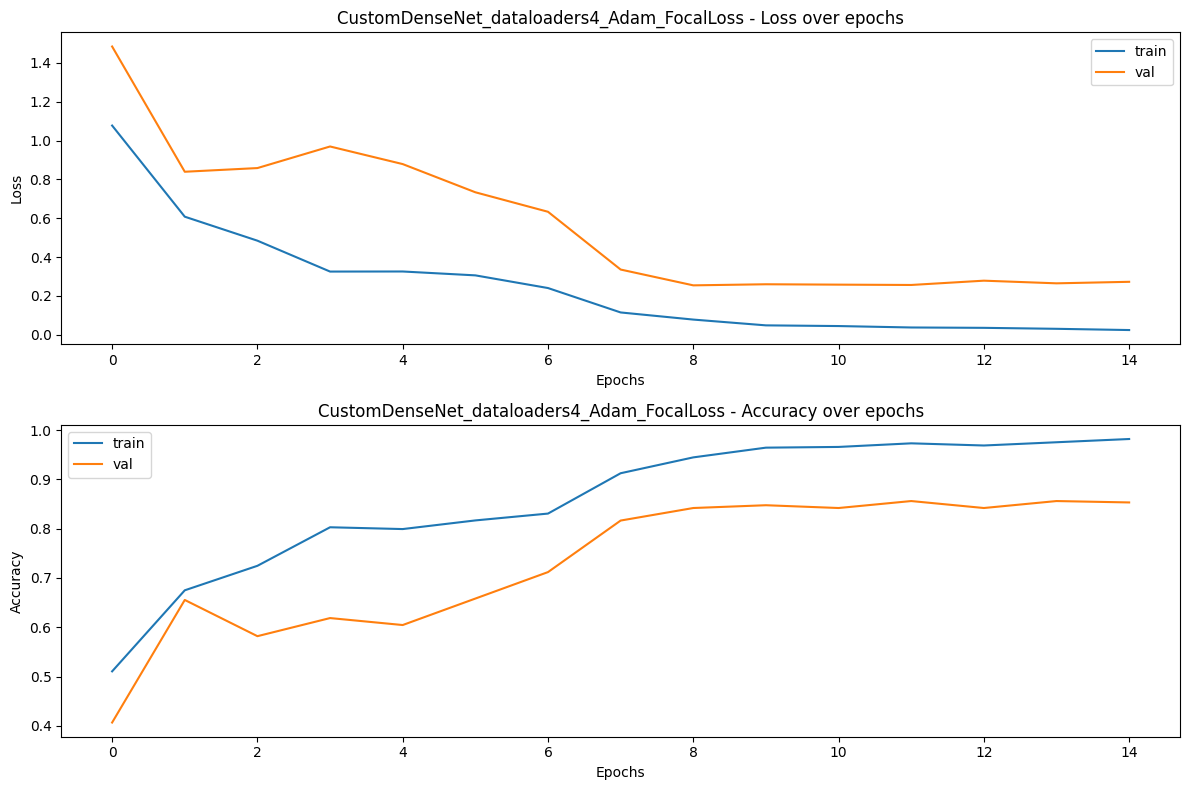


Training with CustomDenseNet, dataloaders5, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.3141 Acc: 0.4397
val Loss: 1.5768 Acc: 0.4040

Epoch 1/14
----------
train Loss: 0.8592 Acc: 0.5880
val Loss: 0.8537 Acc: 0.5989

Epoch 2/14
----------
train Loss: 0.6926 Acc: 0.6428
val Loss: 0.7763 Acc: 0.6638

Epoch 3/14
----------
train Loss: 0.5064 Acc: 0.7188
val Loss: 0.9999 Acc: 0.6073

Epoch 4/14
----------
train Loss: 0.4503 Acc: 0.7458
val Loss: 0.7044 Acc: 0.6808

Epoch 5/14
----------
train Loss: 0.4031 Acc: 0.7626
val Loss: 0.5750 Acc: 0.7401

Epoch 6/14
----------
train Loss: 0.3276 Acc: 0.8006
val Loss: 0.4849 Acc: 0.7316

Epoch 7/14
----------
train Loss: 0.1885 Acc: 0.8751
val Loss: 0.3612 Acc: 0.8107

Epoch 8/14
----------
train Loss: 0.1191 Acc: 0.9182
val Loss: 0.3380 Acc: 0.8277

Epoch 9/14
----------
train Loss: 0.1042 Acc: 0.9270
val Loss: 0.3558 Acc: 0.8164

Epoch 10/14
----------
train Loss: 0.0829 Acc: 0.9379
val Loss: 0.3692 Acc: 0.7938

Epoch 11/14
----------
tr

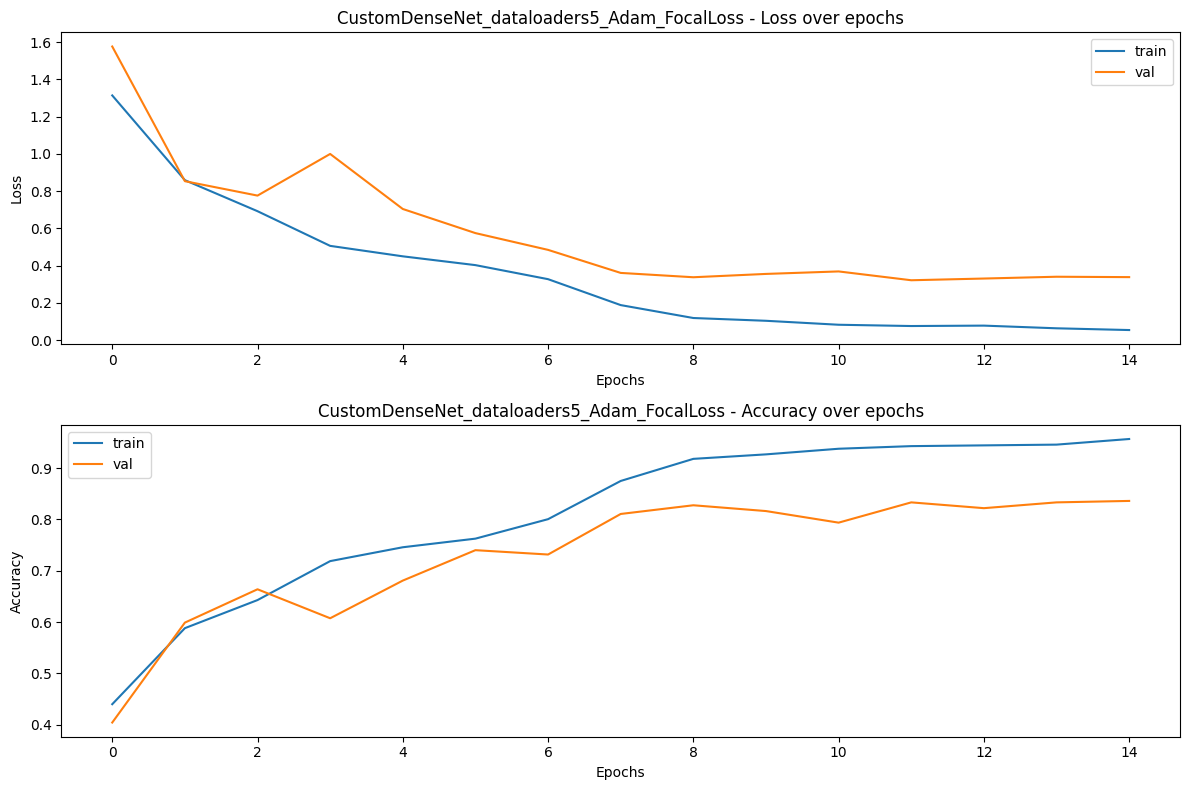

In [21]:
# perform several training runs to compare accuracy on the validation dataset


models_g = [CustomDenseNet]
loss_funcs_g = [FocalLoss] 
loaders_g = ['dataloaders3', 'dataloaders4', 'dataloaders5']
optimizers_g = ['Adam']

best_model_g = None
best_accuracy_g = -1

for model_class in models_g:
  for loader in loaders_g:
        for opt in optimizers_g:
            for loss_func_class in loss_funcs_g:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model_g, best_val_accuracy_g, history_g = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history_g['train_loss'])
                print("Validation loss history:", history_g['val_loss'])
                print("Training accuracy history:", history_g['train_acc'])
                print("Validation accuracy history:", history_g['val_acc'])


                # Plot training curves
                combination_name_g = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history_g, combination_name_g)

                if best_val_accuracy_g > best_accuracy_g:
                  best_model_g = trained_model_g
                  best_combo_g = combination_name_g
                  best_accuracy_g = best_val_accuracy_g
               


#Experiment: Same slice versus different random slice on inference#
Comparing the results with the validation dataset using the same 'center slice' method as for the training data, versus using a random image from each series as the alternative validation dataset. 

In [22]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/model0530a.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)

In [23]:
# Evaluate the model on the random val dataset


model.eval()
val_ran_predictions = []
val_ran_labels = []
_, val_ran_loader, _, _ = get_data_loaders(train_df, val_ran_df, test_df, batch_size, data_transforms=data_transforms2)

for inputs, labels in val_ran_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_ran_predictions.append(predicted.cpu().numpy())
        val_ran_labels.append(labels.cpu().numpy())
val_ran_predictions = np.concatenate(val_ran_predictions, axis=0)
val_ran_labels = np.concatenate(val_ran_labels, axis=0)


save_filename = f"cnn_model_randomval_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_ran_predictions, val_ran_labels, classes, fn=save_filename, saveflag=True)




NameError: ignored

Much lower accuracy when the validation images are randomly selected but the train images are all the midpoint images. Will have to see if training over random train images or the full set of train images will help this. In the meantime, for any inference would select the midpoint images to match what the model was trained on. 

#Experiment: Focal Loss with different alpha values for each class# 
Introducing a new custom loss function (FocalLoss2) which accepts a dictionary of values for the alpha to specify the degree of emphasis for each class. This may negatively impact the overall accuracy, however. 

In [21]:
import torch.nn.functional as F

class FocalLoss2(nn.Module):
    def __init__(self, alpha_dict=None, gamma=2, reduction='mean'):
        super(FocalLoss2, self).__init__()
        self.alpha_dict = alpha_dict
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')

        if self.alpha is not None:
            alpha_weights = torch.ones_like(CE_loss)
            alpha_weights *= self.alpha  # Initialize weights with alpha for all classes

            for cls, weight in self.alpha.items():
                alpha_weights[targets == cls] = weight  # Update weights for specified classes

            CE_loss *= alpha_weights

        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)



class FocalLoss3(nn.Module):
    def __init__(self, alpha_list, gamma=2, reduction='mean'):
        super(FocalLoss3, self).__init__()
        self.alpha_list = torch.tensor((alpha_list), dtype=torch.float32)  # Convert values to a list
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        device = inputs.device
        pt = torch.exp(-ce_loss)
        alpha_weights = self.alpha_list[targets.to(device)].to(device)
        focal_loss = (alpha_weights * (1 - pt) ** self.gamma * ce_loss)
        if self.reduction == 'mean':
          focal_loss = torch.mean(focal_loss)
          
        return focal_loss


In [22]:
alpha_list = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1}
f_loss_fn = FocalLoss3(alpha_list = alpha_list, gamma=2)


In [ ]:
device

device(type='cuda')

In [23]:
train_f_loader, val_f_loader, test_f_loader, size = get_data_loaders(train_df, val_df, test_df, batch_size=8, data_transforms=data_transforms2)
dataloaders_f = {'train': train_f_loader, 'val': val_f_loader, 'test': test_f_loader}

In [25]:
# perform focal loss experiment on the validation dataset
# Evaluate the model on the test dataset
#model = loaded_model.to(device)
models = [CustomDenseNet]
loaders = ['dataloaders2']
optimizers = ['Adam']
loss_funcs = [f_loss_fn, FocalLoss]

best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class}, {loader}, {opt}, {loss_func_class}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Instantiate the selected loss function
                criterion = loss_func_class

                
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy
               


Training with <class 'cnn.cnn_model.CustomDenseNet'>, dataloaders2, Adam, FocalLoss3()
Epoch 0/14
----------


ValueError: ignored

# Attempt at using Vision Transformers#

In [ ]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



In [ ]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata_deit = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata_deit = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata_deit = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader_deit = DataLoader(train_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader_deit = DataLoader(val_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader_deit = DataLoader(test_imgdata_deit, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes_deit = {'train': len(train_imgdata_deit), 'val': len(val_imgdata_deit)}

    return train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit



train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



In [ ]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [ ]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = criterion.to(device)
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = torch.tensor(labels, dtype=torch.long).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc = epoch_acc.item() 


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #print(f'Best val Acc: {best_acc:4f}')


    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history




In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
deit_model = deit_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deit_model.parameters())

dataloaders = {'train': train_loader_deit, 'val': val_loader_deit}

deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, dataloaders, criterion, optimizer, num_epochs=25)

deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load pre-trained DeiT model and adjust the classifier for your number of classes
# deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
# num_classes = len(classes) # classes is your list of classes
# deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
# deit_model.to(device)

# # Define your loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

# num_epochs = 20

# # Start training
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader_deit, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = deit_model(inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0


#Evaluating the best model on the test dataset


[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.91      0.87      0.89        61
           6       0.85      1.00      0.92        17
           7       0.95      0.95      0.95        22
           8       0.93      1.00      0.97        43
           9       1.00      0.93      0.96        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         3
          14       0.92      1.00      0.96        23
          16       0.67      0.73      0.70        22
          17       0.95      0.95      0.95        21
          18       1.00      0.96      0.98        28
          19       1.00      1.00      1.00        23
          23       0.48      0.65      0.55        20
          25       0.92   

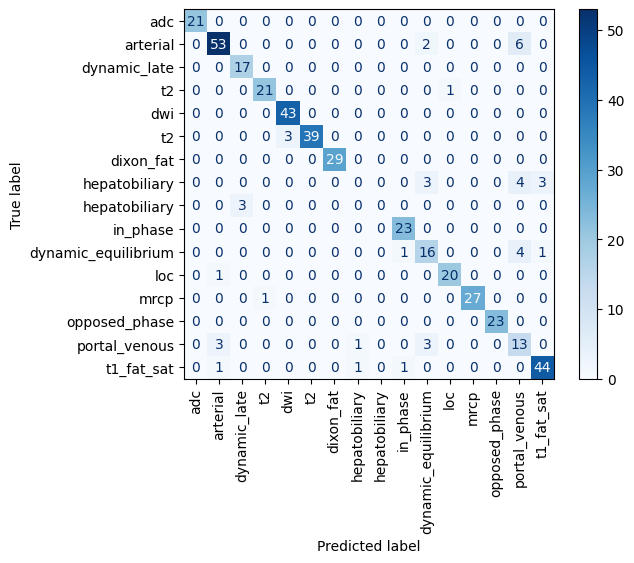

<Figure size 2500x2500 with 0 Axes>

In [24]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/model0530a.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)

model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='DenseNetFL', saveflag=True)







In [25]:
test_df['predictions'] = [classes[x] for x in test_predictions]
incorrect_df = test_df.copy()
incorrect_df = incorrect_df[incorrect_df.predictions!=incorrect_df.label]
incorrect_df = incorrect_df.reset_index()
incorrect_df.to_pickle('/content/gdrive/MyDrive/incorrect_df0604a.pkl')
test_df.to_pickle('/content/gdrive/MyDrive/test_with_preds0604a.pkl')

In [26]:
class ImgDatasetForVis(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        img_file = self.data_df.fname[idx]
        ds = pydicom.dcmread(img_file)
        img = np.array(ds.pixel_array, dtype=np.float32)
        img = img[np.newaxis]
        img = torch.from_numpy(np.asarray(img))
        if self.transform: 
          img = self.transform(img)
        
        
        labl = self.data_df.label[idx]
        adjusted_label = classes.index(labl)
        y = torch.tensor(adjusted_label, dtype=torch.long)
        
        return img, y, img_file  # also return file path


# Create a data loader for visualization
vis_dataset = ImgDatasetForVis(test_df, data_transforms['test'])  
vis_loader = DataLoader(vis_dataset, batch_size=batch_size, shuffle=False)
incorrect_dataset= ImgDatasetForVis(incorrect_df, data_transforms['test'])
incorrect_loader = DataLoader(incorrect_dataset, batch_size=batch_size, shuffle=False)



In [27]:

def visualize_results2(model, dataloader, device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels, filenames = next(iter(dataloader))
        print(filenames)
        #original_images = images.clone() # Store a copy of original images
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(20, 20))
    grid_size = 4
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(grid_size, grid_size, idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(classes[preds[idx]])]['short'], abd_label_dict[str(classes[labels[idx]])]['short']),
            color=("green" if preds[idx]==labels[idx] else "red"))

    return

In [28]:
# Now use 'vis_loader' in your visualization function
visualize_results2(best_model, vis_loader, device)

NameError: ignored

In [ ]:
## show incorrect predictions

def visualize_incorrect(df):
   
    # Get a batch of validation images
    filenames = df.fname
    preds = df.predictions 
    labels = df.label
        
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(50, 50))
    grid_size = 4
    fontsize = 24

    for idx, row in df.iterrows():
        #print(idx)
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

       
        #ax = fig.add_subplot(grid_size, int(len(preds)/grid_size), idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
            color=("green" if pred==label else "red"), font_size=font_size)

    return

In [ ]:


def visualize_incorrect2(df):
    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Set plot parameters for publication quality
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 14
    plt.rcParams['lines.linewidth'] = 2

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure()
    grid_size = 4

    for idx, row in df.iterrows():
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

        ds = pydicom.dcmread(filename)
        image = ds.pixel_array

        # Apply center crop
        image = center_crop(image)

        # Increase brightness
        image = image * 1.5

        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
                     color=("green" if pred==label else "red"))

        # Remove the axis labels
        ax.axis('off')

    plt.tight_layout()

    # Save the plot as a high-resolution image
    plt.savefig('publication-quality-plot_incorrect.png', dpi=300)

    plt.show()



In [ ]:
visualize_incorrect2(incorrect_df[:16])

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

def visualize_grad_cam(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0)  # Add batch dimension
    image.requires_grad = True

    # Forward pass
    output = model(image)
    _, predicted_class = torch.max(output, 1)

    # Compute gradients
    model.zero_grad()
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0, target_class] = 1
    output.backward(gradient=one_hot_output)

    # Get the gradients of the last convolutional layer
    gradients = model.get_activations_gradient()

    # Pool the gradients across channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Get the activations of the last convolutional layer
    activations = model.get_activations(image).detach()

    # Weight the activations by the gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the weighted activations along the channels dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    # Resize the heatmap to match the image size
    heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(image.size(2), image.size(3)), mode="bilinear", align_corners=False)
    heatmap = heatmap.squeeze().numpy()

    # Plot the heatmap and the original image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.squeeze().permute(1, 2, 0))
    ax1.axis('off')
    ax1.set_title('Original Image')
    ax2.imshow(image.squeeze().permute(1, 2, 0))
    ax2.imshow(heatmap, alpha=0.5, cmap='jet')
    ax2.axis('off')
    ax2.set_title('Grad-CAM Heatmap')
    plt.tight_layout()
    plt.show()

# Usage:
model = YourModel()  # Replace with your own model
image = ...  # Load or generate the input image
target_class = 0  # Specify the target class for visualization
visualize_grad_cam(model, image, target_class)
